# Task 1.1 - Modal → Amodal Mask Prediction Baseline

In [19]:
!tar -xvzf "ff5da6d6ecae486bb294aeaf5ee8f8a1.tar.gz" -C /content

Streaming output truncated to the last 5000 lines.
ff5da6d6ecae486bb294aeaf5ee8f8a1/camera_0001/obj_0002/segmentation_00019.png
ff5da6d6ecae486bb294aeaf5ee8f8a1/camera_0001/obj_0002/depth_00000.tiff
ff5da6d6ecae486bb294aeaf5ee8f8a1/camera_0001/obj_0002/segmentation_00017.png
ff5da6d6ecae486bb294aeaf5ee8f8a1/camera_0001/obj_0002/segmentation_00010.png
ff5da6d6ecae486bb294aeaf5ee8f8a1/camera_0001/obj_0002/rgba_00014.png
ff5da6d6ecae486bb294aeaf5ee8f8a1/camera_0001/obj_0002/rgba_00013.png
ff5da6d6ecae486bb294aeaf5ee8f8a1/camera_0001/obj_0002/depth_00005.tiff
ff5da6d6ecae486bb294aeaf5ee8f8a1/camera_0001/obj_0002/depth_00019.tiff
ff5da6d6ecae486bb294aeaf5ee8f8a1/camera_0001/obj_0002/segmentation_00009.png
ff5da6d6ecae486bb294aeaf5ee8f8a1/camera_0001/obj_0002/segmentation_00007.png
ff5da6d6ecae486bb294aeaf5ee8f8a1/camera_0001/obj_0002/depth_00001.tiff
ff5da6d6ecae486bb294aeaf5ee8f8a1/camera_0001/obj_0002/rgba_00021.png
ff5da6d6ecae486bb294aeaf5ee8f8a1/camera_0001/obj_0002/segmentation_00000.

In [20]:
from pathlib import Path
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
from tqdm import tqdm

# ✅ Robust dataset: matches rgba and segmentation by frame index
class RGBAtoSegmentationDataset(Dataset):
    def __init__(self, root_path):
        self.rgb_paths = []
        self.seg_paths = []

        for obj_folder in root_path.rglob("obj_*"):
            rgba_files = sorted(obj_folder.glob("rgba_*.png"))
            seg_files = sorted(obj_folder.glob("segmentation_*.png"))

            rgba_dict = {f.stem.split("_")[1]: f for f in rgba_files}
            seg_dict = {f.stem.split("_")[1]: f for f in seg_files}

            matched_keys = sorted(set(rgba_dict.keys()) & set(seg_dict.keys()))

            for key in matched_keys:
                self.rgb_paths.append(rgba_dict[key])
                self.seg_paths.append(seg_dict[key])

        assert len(self.rgb_paths) > 0, "No matched rgba-segmentation pairs found."

        self.transform_img = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor()
        ])
        self.transform_mask = transforms.Resize((256, 256))

    def __len__(self):
        return len(self.rgb_paths)

    def __getitem__(self, idx):
        rgba = Image.open(self.rgb_paths[idx]).convert("RGB")
        seg = Image.open(self.seg_paths[idx]).convert("L")

        rgba = self.transform_img(rgba)
        seg = self.transform_mask(seg)
        seg = torch.from_numpy(np.array(seg)).long()
        seg[seg > 0] = 1

        return rgba, seg

# ✅ U-Net model
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=2):
        super(UNet, self).__init__()
        def CBR(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True)
            )
        self.enc1 = nn.Sequential(CBR(in_channels, 64), CBR(64, 64))
        self.enc2 = nn.Sequential(CBR(64, 128), CBR(128, 128))
        self.enc3 = nn.Sequential(CBR(128, 256), CBR(256, 256))
        self.pool = nn.MaxPool2d(2)
        self.up1 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec1 = nn.Sequential(CBR(256, 128), CBR(128, 128))
        self.up2 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec2 = nn.Sequential(CBR(128, 64), CBR(64, 64))
        self.out = nn.Conv2d(64, out_channels, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        d1 = self.up1(e3)
        d1 = torch.cat([d1, e2], dim=1)
        d1 = self.dec1(d1)
        d2 = self.up2(d1)
        d2 = torch.cat([d2, e1], dim=1)
        d2 = self.dec2(d2)
        return self.out(d2)

# ✅ IoU metric
def compute_iou(pred_mask, true_mask):
    pred_mask = torch.argmax(pred_mask, dim=1)
    intersection = ((pred_mask == true_mask) & (true_mask > 0)).sum().float()
    union = ((pred_mask > 0) | (true_mask > 0)).sum().float()
    return (intersection + 1e-6) / (union + 1e-6)

# ✅ Training function
def train_model(model, dataloader, device, epochs=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    model.train()
    for epoch in range(epochs):
        total_loss = 0.0
        total_iou = 0.0
        for img, mask in tqdm(dataloader):
            img, mask = img.to(device), mask.to(device)
            optimizer.zero_grad()
            out = model(img)
            loss = criterion(out, mask)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            total_iou += compute_iou(out, mask).item()
        print(f"Epoch {epoch+1}: Loss = {total_loss/len(dataloader):.4f}, IoU = {total_iou/len(dataloader):.4f}")

# ✅ Set path and run training
root_path = Path("/content/ff5da6d6ecae486bb294aeaf5ee8f8a1")
dataset = RGBAtoSegmentationDataset(root_path)

print("Loaded samples:", len(dataset))
print("First image:", dataset.rgb_paths[0].name)
print("First mask :", dataset.seg_paths[0].name)

loader = DataLoader(dataset, batch_size=2, shuffle=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(in_channels=3, out_channels=2).to(device)

train_model(model, loader, device, epochs=5)



Loaded samples: 2736
First image: rgba_00000.png
First mask : segmentation_00000.png


100%|██████████| 1368/1368 [01:45<00:00, 12.99it/s]


Epoch 1: Loss = 0.0174, IoU = 0.9532


100%|██████████| 1368/1368 [01:48<00:00, 12.60it/s]


Epoch 2: Loss = 0.0012, IoU = 0.9768


100%|██████████| 1368/1368 [01:48<00:00, 12.58it/s]


Epoch 3: Loss = 0.0012, IoU = 0.9797


100%|██████████| 1368/1368 [01:48<00:00, 12.63it/s]


Epoch 4: Loss = 0.0015, IoU = 0.9783


100%|██████████| 1368/1368 [01:48<00:00, 12.62it/s]

Epoch 5: Loss = 0.0008, IoU = 0.9838


Train size: 2188, Test size: 548


100%|██████████| 1094/1094 [01:27<00:00, 12.57it/s]


Epoch 1: Loss = 0.0164, IoU = 0.9599


100%|██████████| 1094/1094 [01:26<00:00, 12.58it/s]


Epoch 2: Loss = 0.0009, IoU = 0.9845


100%|██████████| 1094/1094 [01:27<00:00, 12.57it/s]


Epoch 3: Loss = 0.0021, IoU = 0.9719


100%|██████████| 1094/1094 [01:27<00:00, 12.57it/s]


Epoch 4: Loss = 0.0011, IoU = 0.9803


100%|██████████| 1094/1094 [01:27<00:00, 12.57it/s]


Epoch 5: Loss = 0.0015, IoU = 0.9761


100%|██████████| 274/274 [00:08<00:00, 34.02it/s]


Test IoU = 0.9832


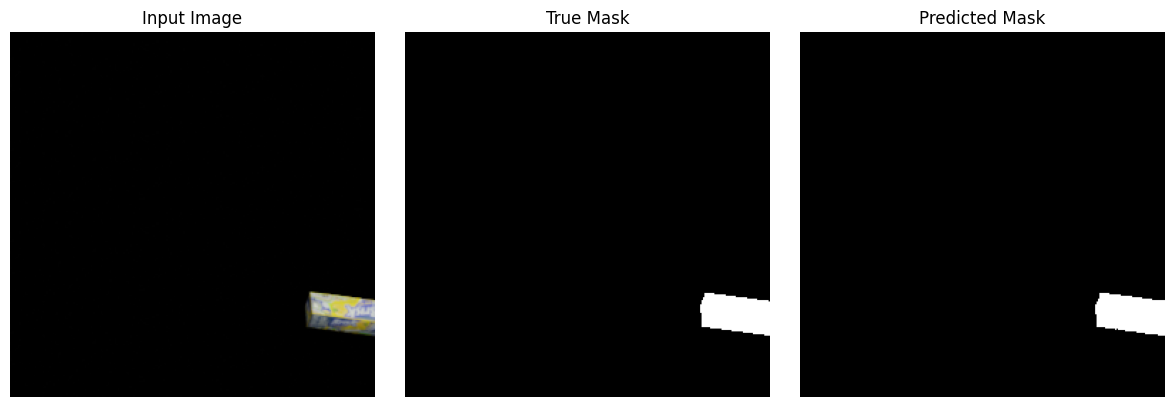

In [21]:
from pathlib import Path
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# Dataset class with safe pair matching
class RGBAtoSegmentationDataset(Dataset):
    def __init__(self, root_path):
        self.rgb_paths = []
        self.seg_paths = []

        for obj_folder in root_path.rglob("obj_*"):
            rgba_files = sorted(obj_folder.glob("rgba_*.png"))
            seg_files = sorted(obj_folder.glob("segmentation_*.png"))

            rgba_dict = {f.stem.split("_")[1]: f for f in rgba_files}
            seg_dict = {f.stem.split("_")[1]: f for f in seg_files}

            matched_keys = sorted(set(rgba_dict.keys()) & set(seg_dict.keys()))
            for key in matched_keys:
                self.rgb_paths.append(rgba_dict[key])
                self.seg_paths.append(seg_dict[key])

        assert len(self.rgb_paths) > 0, "No matched rgba-segmentation pairs found."

        self.transform_img = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor()
        ])
        self.transform_mask = transforms.Resize((256, 256))

    def __len__(self):
        return len(self.rgb_paths)

    def __getitem__(self, idx):
        rgba = Image.open(self.rgb_paths[idx]).convert("RGB")
        seg = Image.open(self.seg_paths[idx]).convert("L")

        rgba = self.transform_img(rgba)
        seg = self.transform_mask(seg)
        seg = torch.from_numpy(np.array(seg)).long()
        seg[seg > 0] = 1
        return rgba, seg

# U-Net
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=2):
        super(UNet, self).__init__()
        def CBR(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True)
            )
        self.enc1 = nn.Sequential(CBR(in_channels, 64), CBR(64, 64))
        self.enc2 = nn.Sequential(CBR(64, 128), CBR(128, 128))
        self.enc3 = nn.Sequential(CBR(128, 256), CBR(256, 256))
        self.pool = nn.MaxPool2d(2)
        self.up1 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec1 = nn.Sequential(CBR(256, 128), CBR(128, 128))
        self.up2 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec2 = nn.Sequential(CBR(128, 64), CBR(64, 64))
        self.out = nn.Conv2d(64, out_channels, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        d1 = self.up1(e3)
        d1 = torch.cat([d1, e2], dim=1)
        d1 = self.dec1(d1)
        d2 = self.up2(d1)
        d2 = torch.cat([d2, e1], dim=1)
        d2 = self.dec2(d2)
        return self.out(d2)

# IoU
def compute_iou(pred_mask, true_mask):
    pred_mask = torch.argmax(pred_mask, dim=1)
    intersection = ((pred_mask == true_mask) & (true_mask > 0)).sum().float()
    union = ((pred_mask > 0) | (true_mask > 0)).sum().float()
    return (intersection + 1e-6) / (union + 1e-6)

# Training
def train_model(model, dataloader, device, epochs=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    model.train()
    for epoch in range(epochs):
        total_loss = 0.0
        total_iou = 0.0
        for img, mask in tqdm(dataloader):
            img, mask = img.to(device), mask.to(device)
            optimizer.zero_grad()
            out = model(img)
            loss = criterion(out, mask)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            total_iou += compute_iou(out, mask).item()
        print(f"Epoch {epoch+1}: Loss = {total_loss/len(dataloader):.4f}, IoU = {total_iou/len(dataloader):.4f}")

# Evaluation
def evaluate_model(model, dataloader, device):
    model.eval()
    total_iou = 0.0
    with torch.no_grad():
        for img, mask in tqdm(dataloader):
            img, mask = img.to(device), mask.to(device)
            out = model(img)
            total_iou += compute_iou(out, mask).item()
    print(f"Test IoU = {total_iou / len(dataloader):.4f}")

# Optional: Visualize sample prediction
def visualize_prediction(model, dataset, device, idx=0):
    model.eval()
    img, true_mask = dataset[idx]
    with torch.no_grad():
        pred = model(img.unsqueeze(0).to(device))
        pred_mask = torch.argmax(pred.squeeze(), dim=0).cpu().numpy()
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(img.permute(1, 2, 0))
    axs[0].set_title("Input Image")
    axs[1].imshow(true_mask, cmap="gray")
    axs[1].set_title("True Mask")
    axs[2].imshow(pred_mask, cmap="gray")
    axs[2].set_title("Predicted Mask")
    for ax in axs:
        ax.axis("off")
    plt.tight_layout()
    plt.show()

# Main script
root_path = Path("/content/ff5da6d6ecae486bb294aeaf5ee8f8a1")
dataset = RGBAtoSegmentationDataset(root_path)

# Split into train/test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_set, test_set = random_split(dataset, [train_size, test_size])

print(f"Train size: {len(train_set)}, Test size: {len(test_set)}")

train_loader = DataLoader(train_set, batch_size=2, shuffle=True)
test_loader = DataLoader(test_set, batch_size=2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(in_channels=3, out_channels=2).to(device)

# Train and evaluate
train_model(model, train_loader, device, epochs=5)
evaluate_model(model, test_loader, device)

# Visualize prediction from test set
visualize_prediction(model, test_set, device, idx=0)


Found 114 object folders.


Infer middle frames:   0%|          | 0/114 [00:00<?, ?it/s]

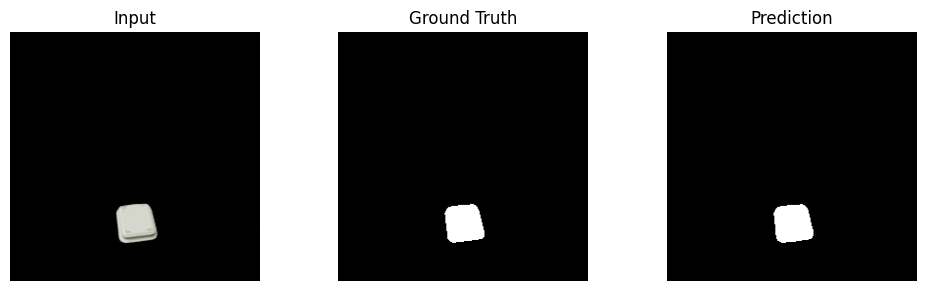

Infer middle frames:   1%|          | 1/114 [00:00<00:18,  6.10it/s]

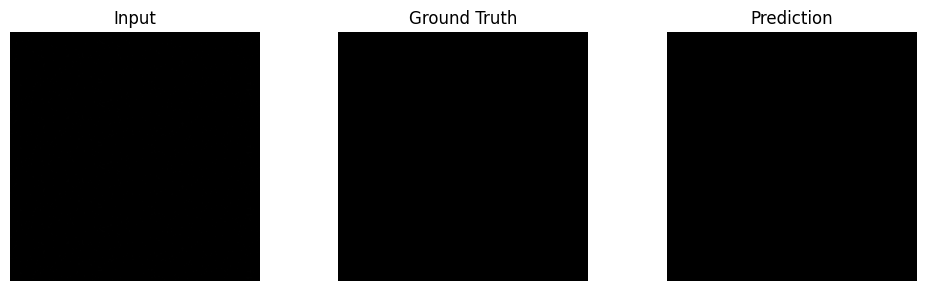

Infer middle frames:   2%|▏         | 2/114 [00:00<00:18,  6.14it/s]

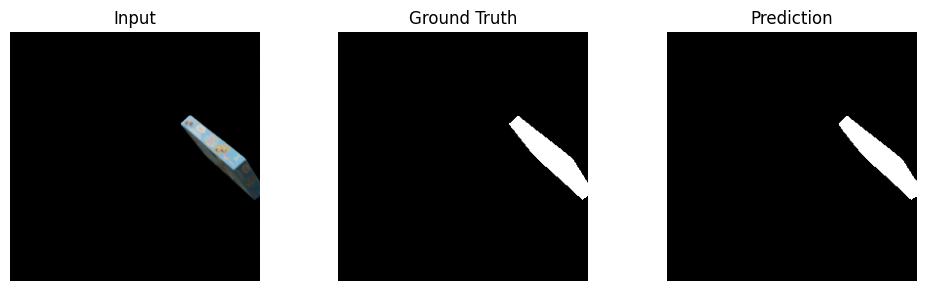

Infer middle frames:   3%|▎         | 3/114 [00:00<00:17,  6.17it/s]

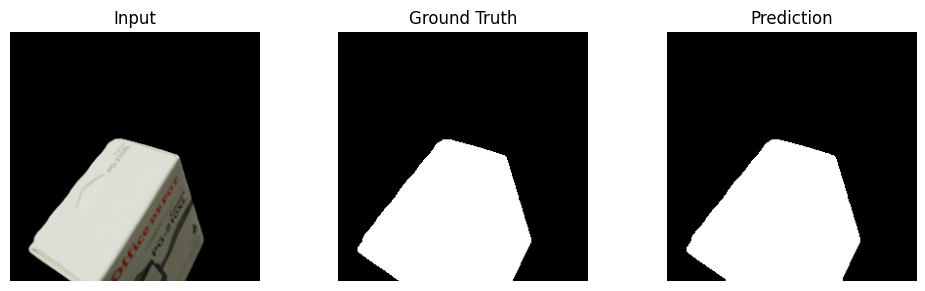

Infer middle frames:   4%|▎         | 4/114 [00:00<00:18,  6.02it/s]

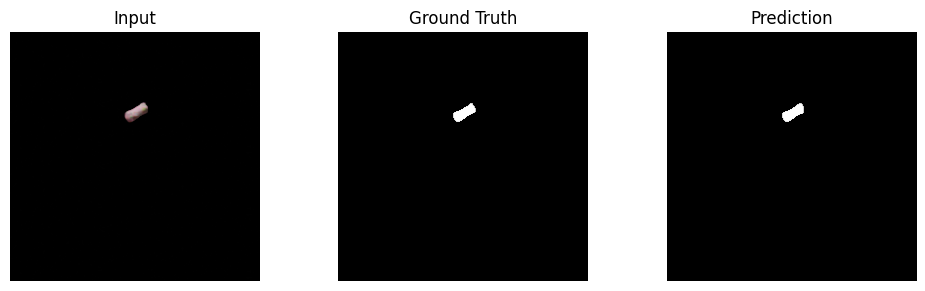

Infer middle frames:   4%|▍         | 5/114 [00:00<00:18,  5.90it/s]

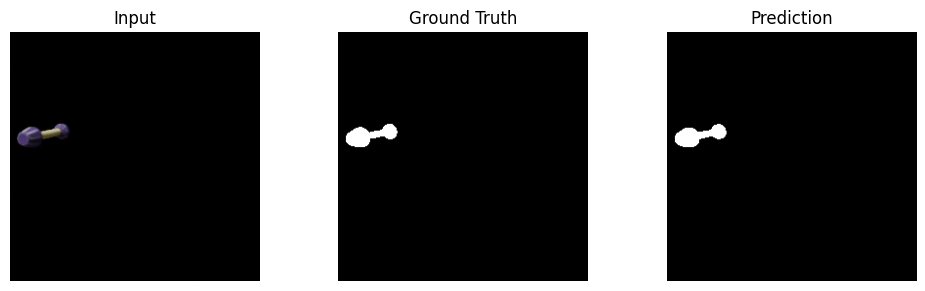

Infer middle frames:   5%|▌         | 6/114 [00:00<00:18,  5.96it/s]

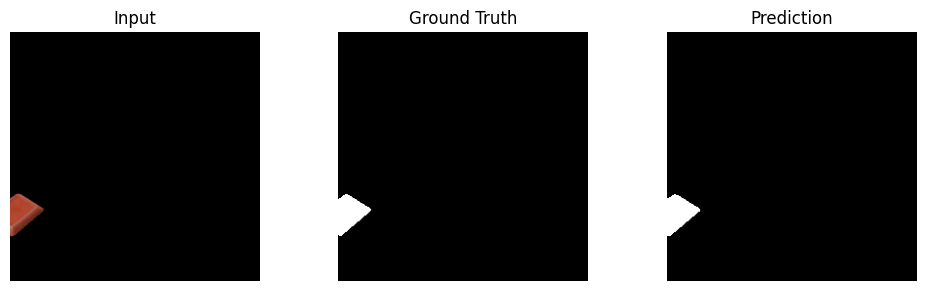

Infer middle frames:   6%|▌         | 7/114 [00:01<00:17,  5.98it/s]

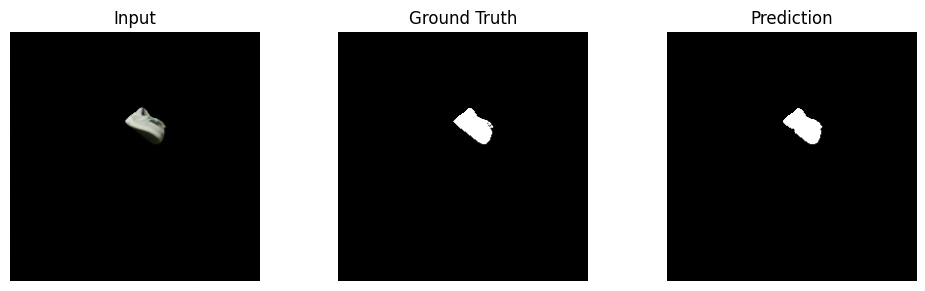

Infer middle frames:   7%|▋         | 8/114 [00:01<00:17,  6.05it/s]

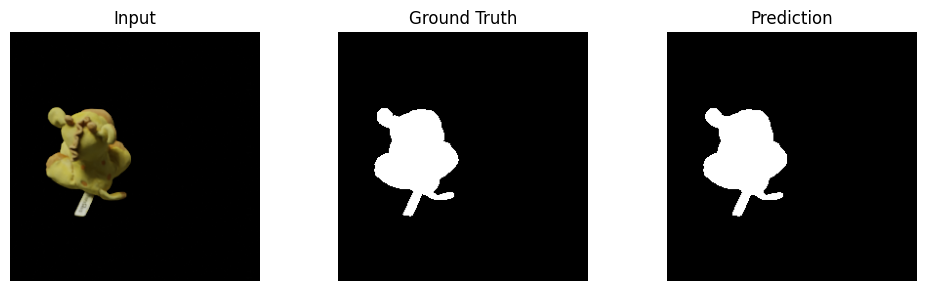

Infer middle frames:   8%|▊         | 9/114 [00:01<00:17,  6.09it/s]

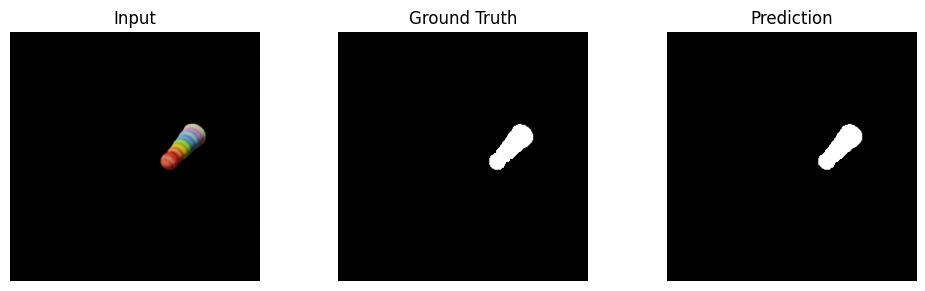

Infer middle frames:   9%|▉         | 10/114 [00:01<00:17,  6.07it/s]

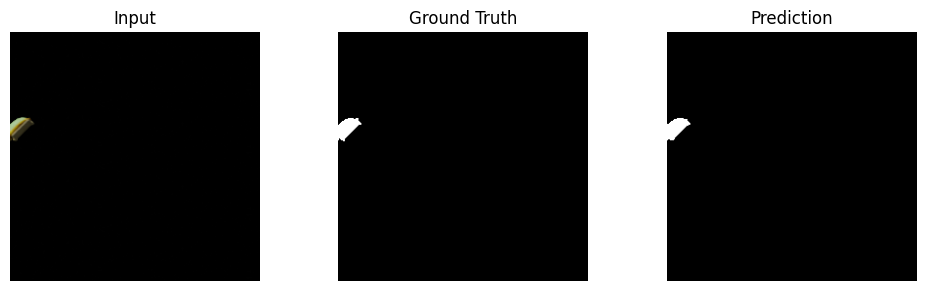

Infer middle frames:  10%|▉         | 11/114 [00:01<00:17,  5.89it/s]

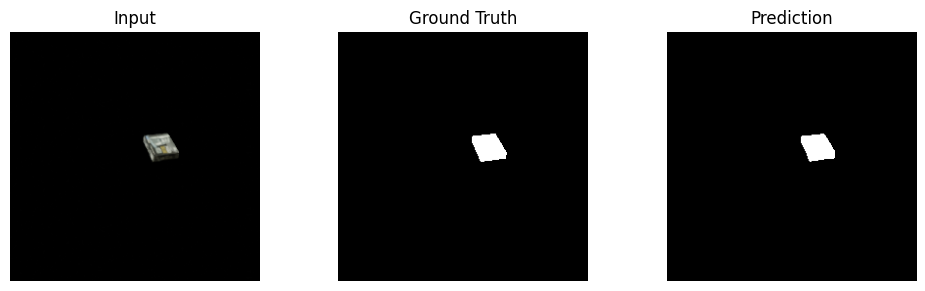

Infer middle frames:  11%|█         | 12/114 [00:02<00:23,  4.35it/s]

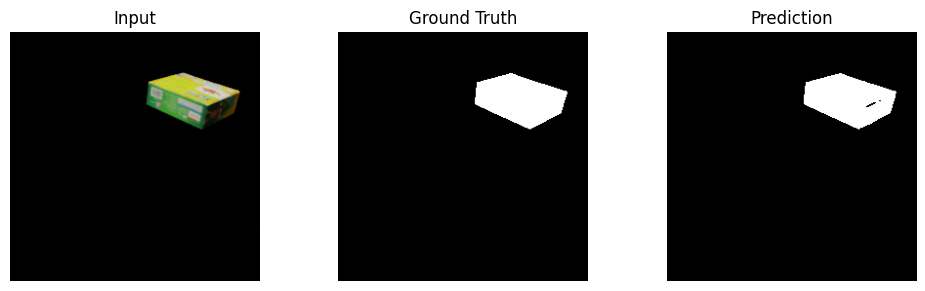

Infer middle frames:  11%|█▏        | 13/114 [00:02<00:21,  4.71it/s]

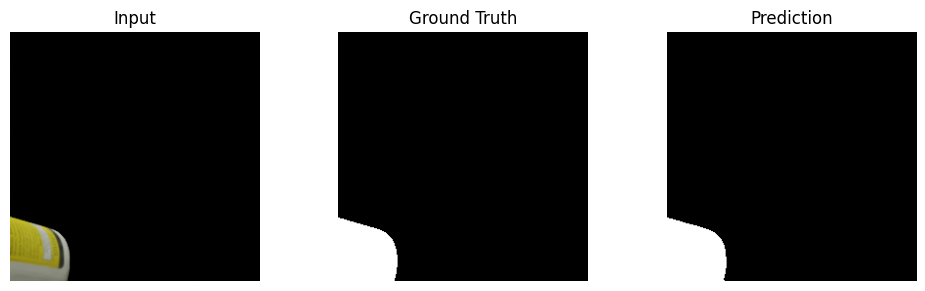

Infer middle frames:  12%|█▏        | 14/114 [00:02<00:20,  4.98it/s]

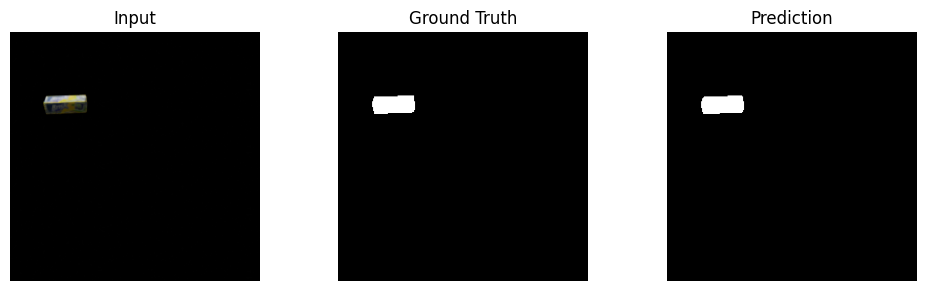

Infer middle frames:  13%|█▎        | 15/114 [00:02<00:18,  5.22it/s]

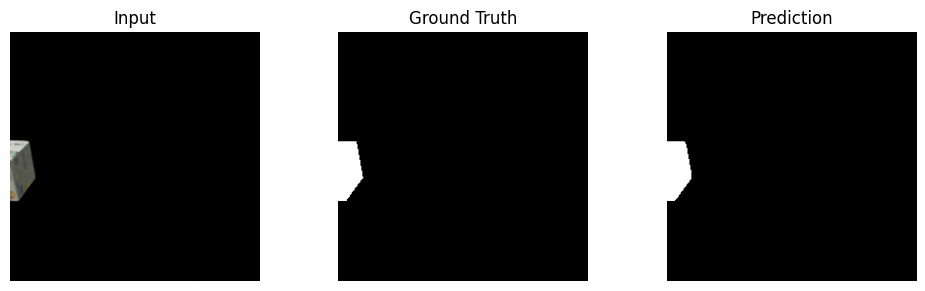

Infer middle frames:  14%|█▍        | 16/114 [00:02<00:18,  5.29it/s]

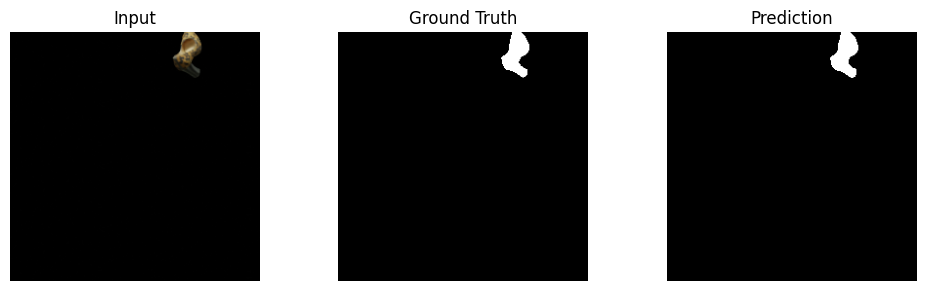

Infer middle frames:  15%|█▍        | 17/114 [00:03<00:17,  5.46it/s]

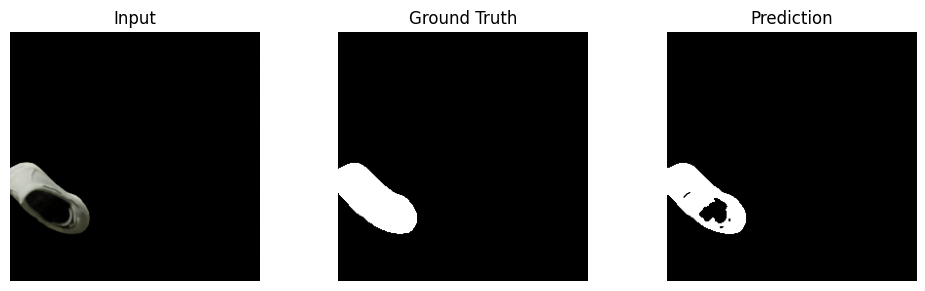

Infer middle frames:  16%|█▌        | 18/114 [00:03<00:17,  5.54it/s]

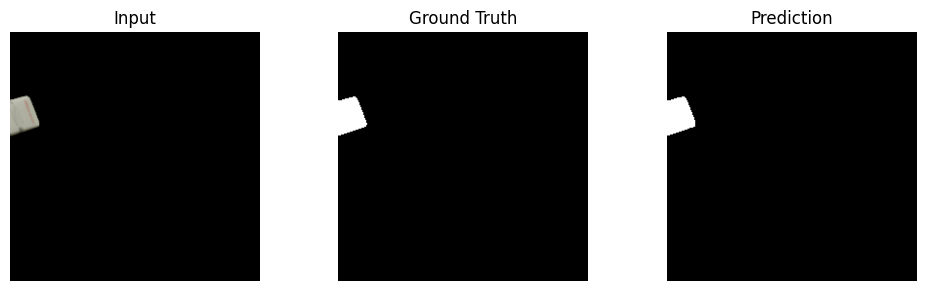

Infer middle frames:  17%|█▋        | 19/114 [00:03<00:16,  5.64it/s]

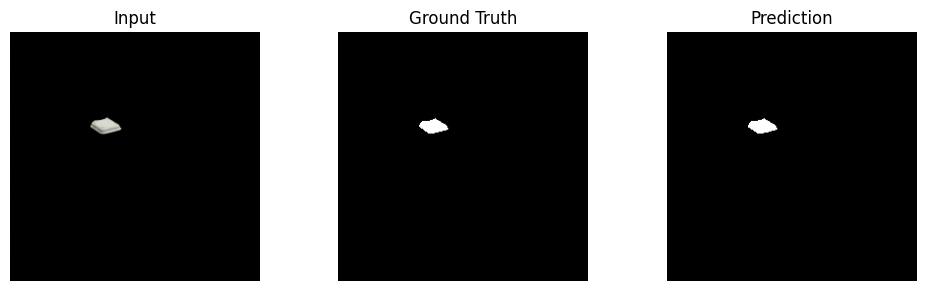

Infer middle frames:  18%|█▊        | 20/114 [00:03<00:16,  5.68it/s]

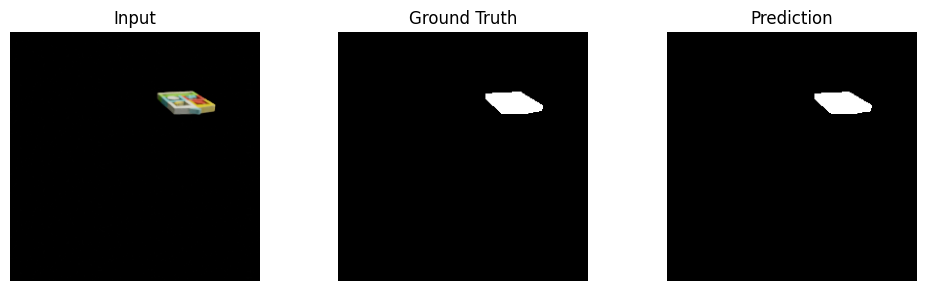

Infer middle frames:  18%|█▊        | 21/114 [00:03<00:16,  5.72it/s]

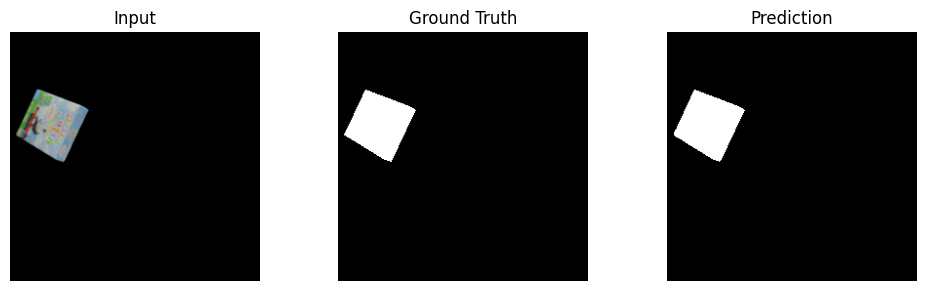

Infer middle frames:  19%|█▉        | 22/114 [00:03<00:16,  5.62it/s]

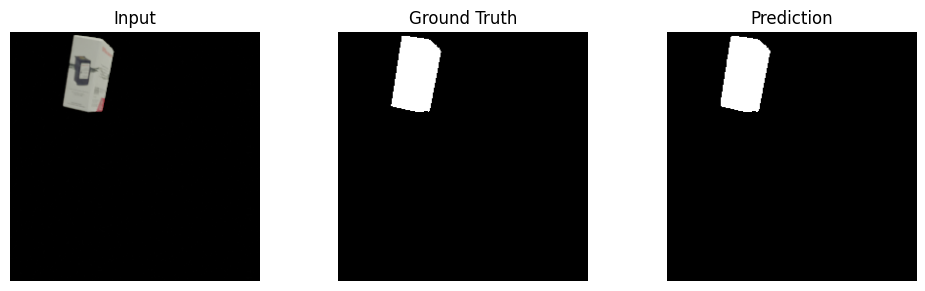

Infer middle frames:  20%|██        | 23/114 [00:04<00:16,  5.68it/s]

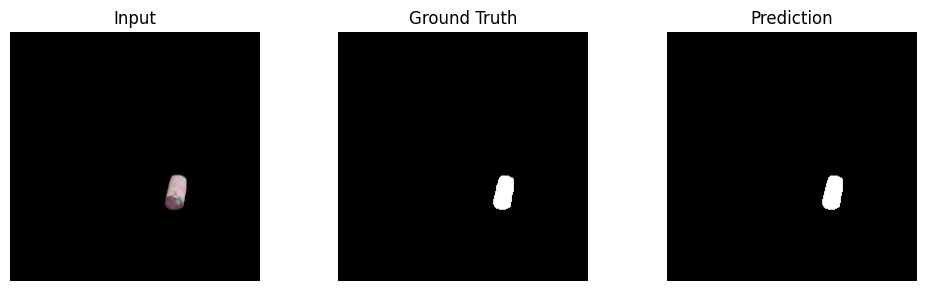

Infer middle frames:  21%|██        | 24/114 [00:04<00:15,  5.71it/s]

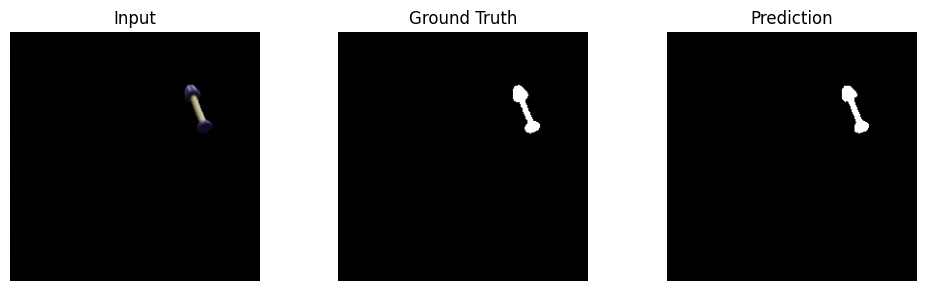

Infer middle frames:  22%|██▏       | 25/114 [00:04<00:15,  5.76it/s]

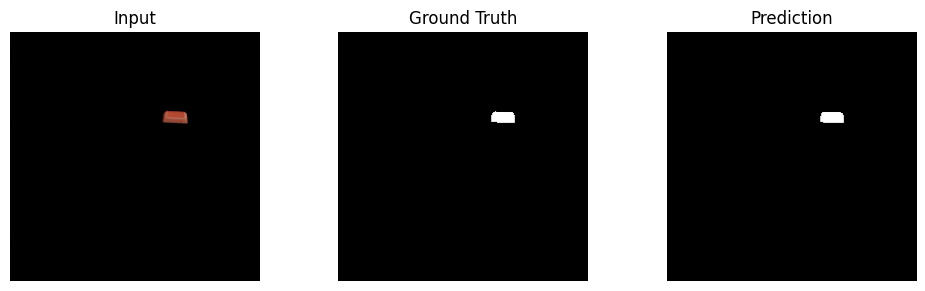

Infer middle frames:  23%|██▎       | 26/114 [00:04<00:15,  5.78it/s]

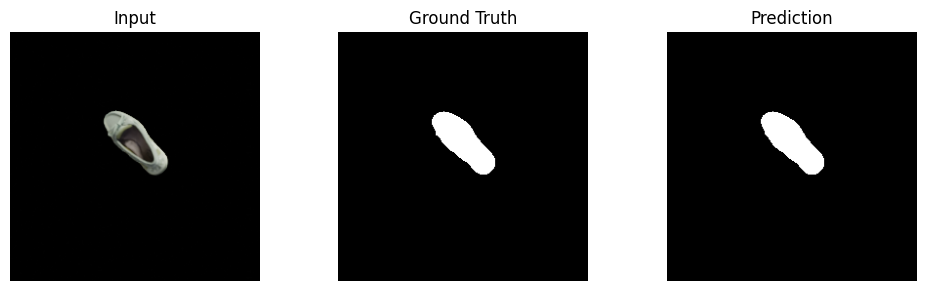

Infer middle frames:  24%|██▎       | 27/114 [00:05<00:22,  3.89it/s]

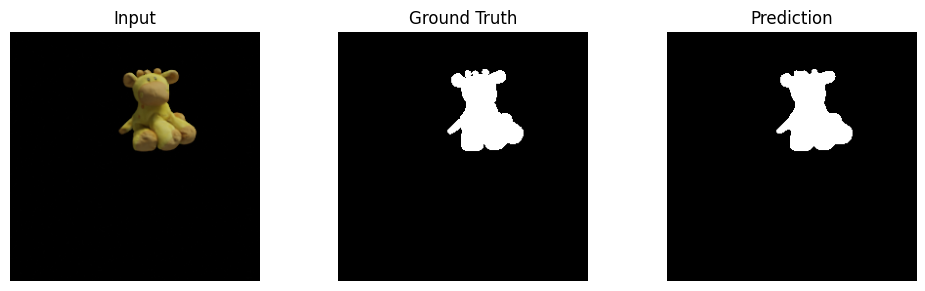

Infer middle frames:  25%|██▍       | 28/114 [00:05<00:22,  3.89it/s]

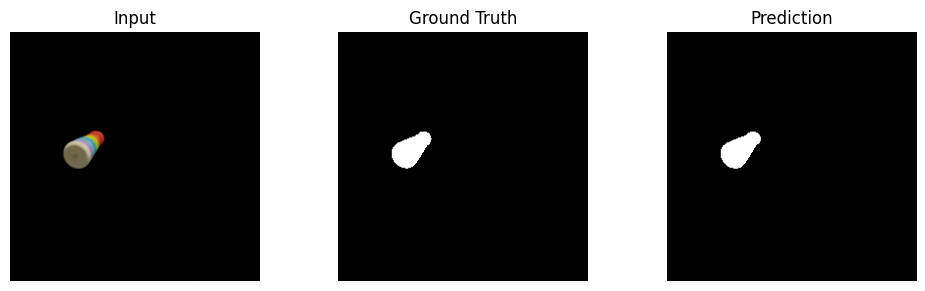

Infer middle frames:  25%|██▌       | 29/114 [00:05<00:22,  3.85it/s]

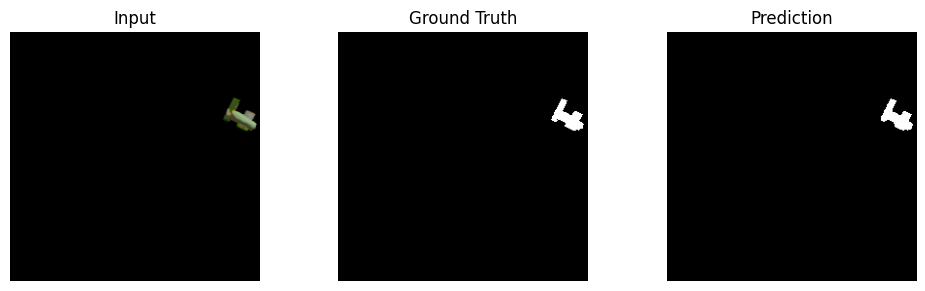

Infer middle frames:  26%|██▋       | 30/114 [00:05<00:21,  3.93it/s]

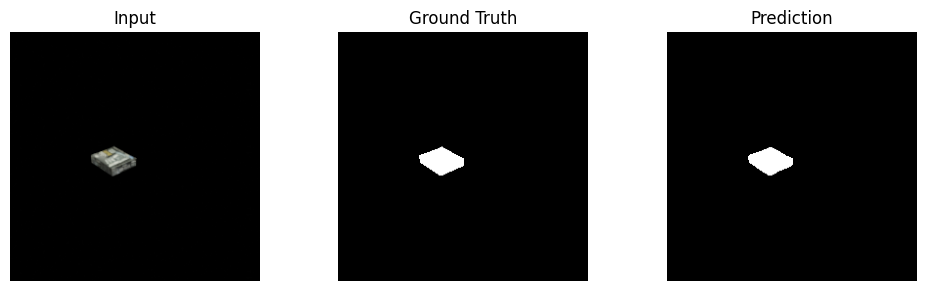

Infer middle frames:  27%|██▋       | 31/114 [00:06<00:21,  3.85it/s]

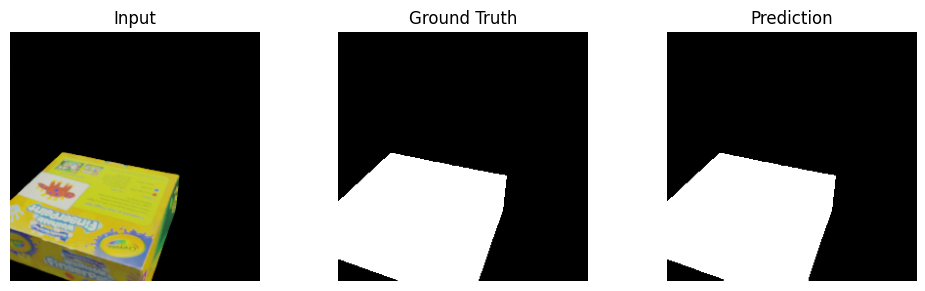

Infer middle frames:  28%|██▊       | 32/114 [00:06<00:21,  3.89it/s]

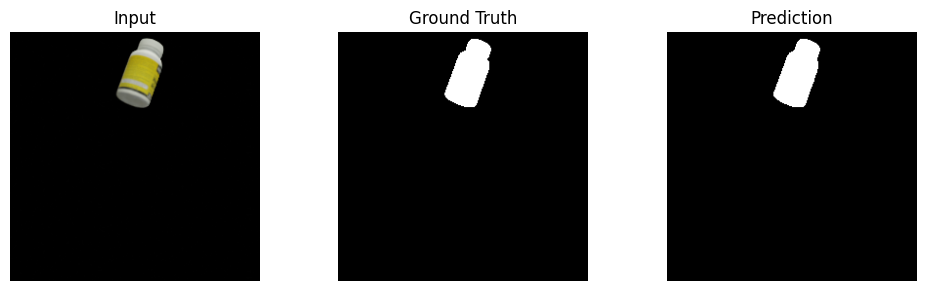

Infer middle frames:  29%|██▉       | 33/114 [00:06<00:20,  3.87it/s]

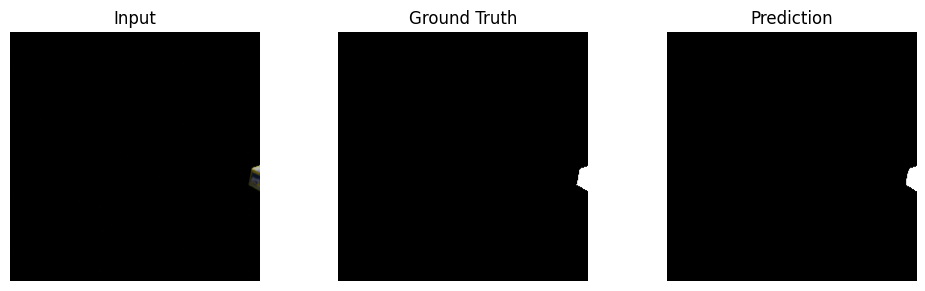

Infer middle frames:  30%|██▉       | 34/114 [00:06<00:20,  3.86it/s]

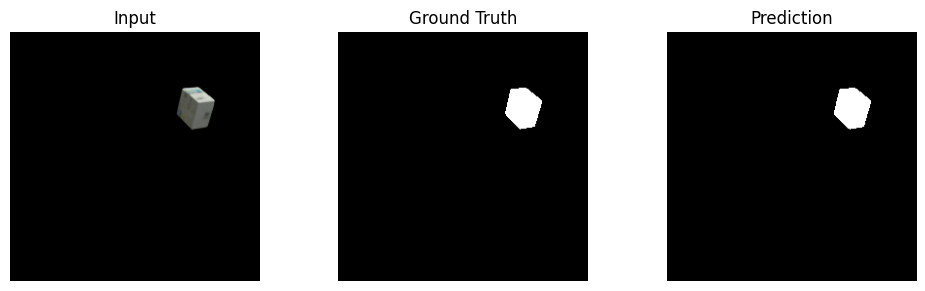

Infer middle frames:  31%|███       | 35/114 [00:07<00:21,  3.75it/s]

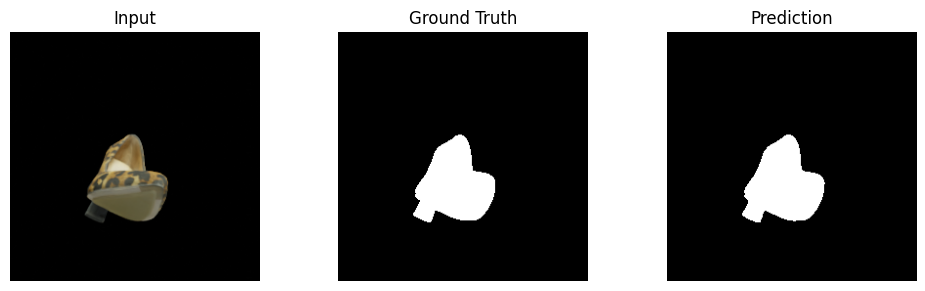

Infer middle frames:  32%|███▏      | 36/114 [00:07<00:19,  4.03it/s]

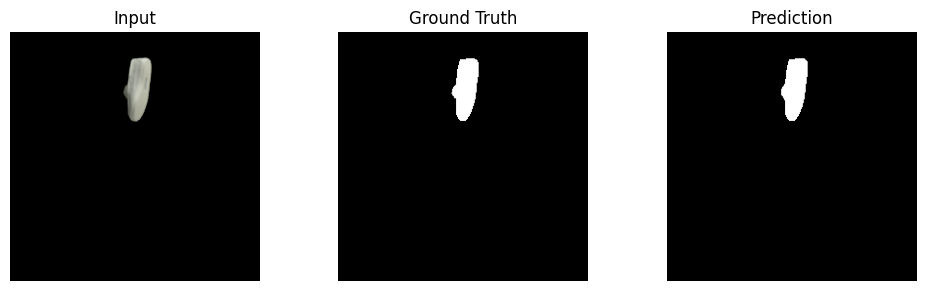

Infer middle frames:  32%|███▏      | 37/114 [00:07<00:17,  4.45it/s]

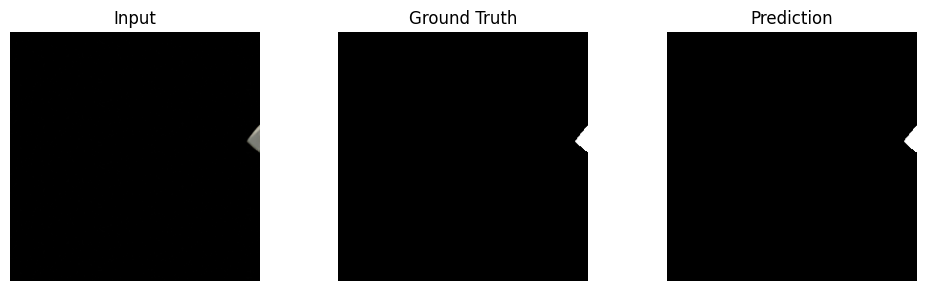

Infer middle frames:  33%|███▎      | 38/114 [00:07<00:15,  4.78it/s]

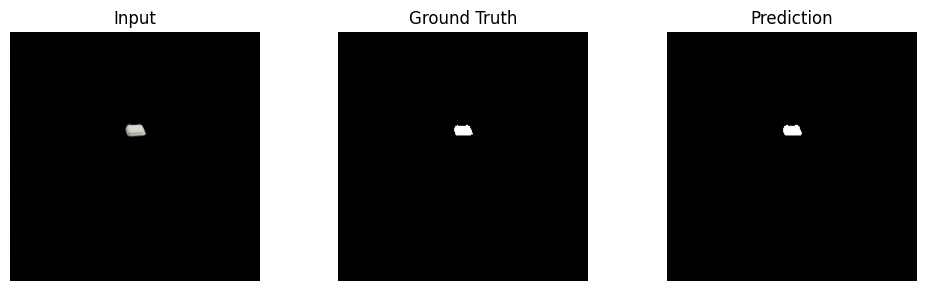

Infer middle frames:  34%|███▍      | 39/114 [00:07<00:14,  5.05it/s]

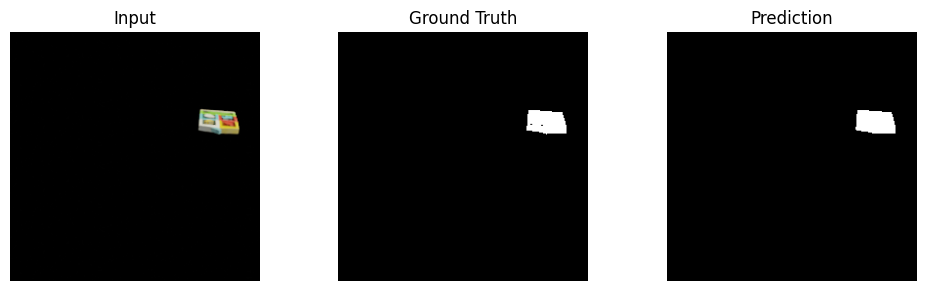

Infer middle frames:  35%|███▌      | 40/114 [00:08<00:14,  5.17it/s]

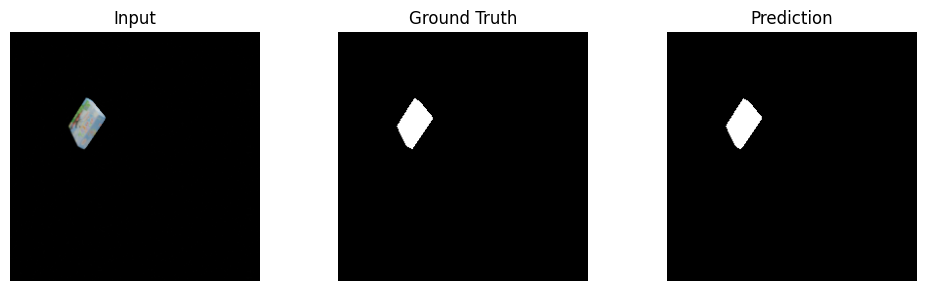

Infer middle frames:  36%|███▌      | 41/114 [00:08<00:14,  5.18it/s]

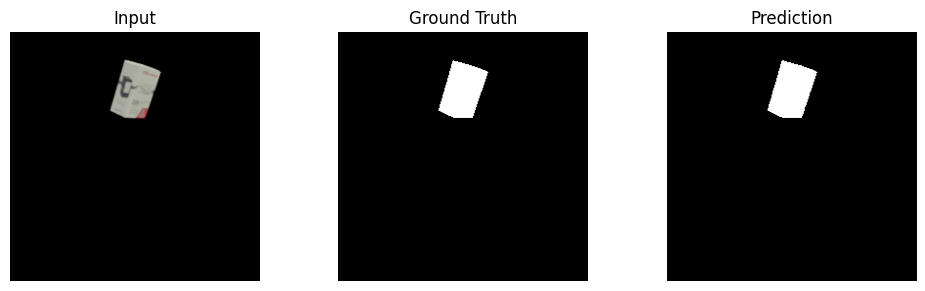

Infer middle frames:  37%|███▋      | 42/114 [00:08<00:13,  5.36it/s]

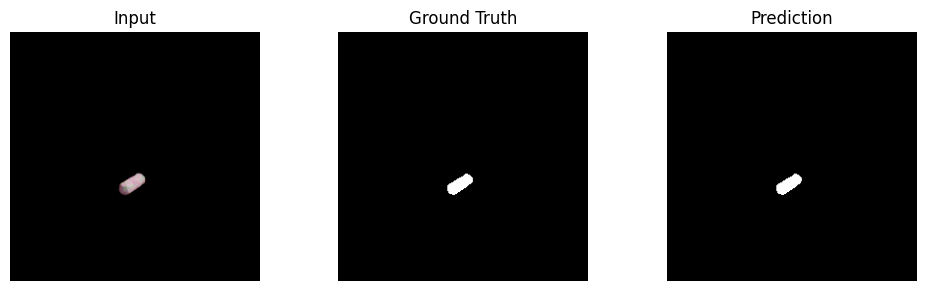

Infer middle frames:  38%|███▊      | 43/114 [00:08<00:13,  5.38it/s]

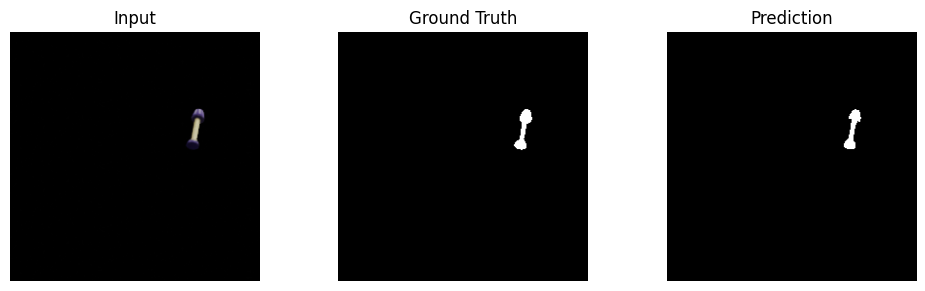

Infer middle frames:  39%|███▊      | 44/114 [00:09<00:17,  4.10it/s]

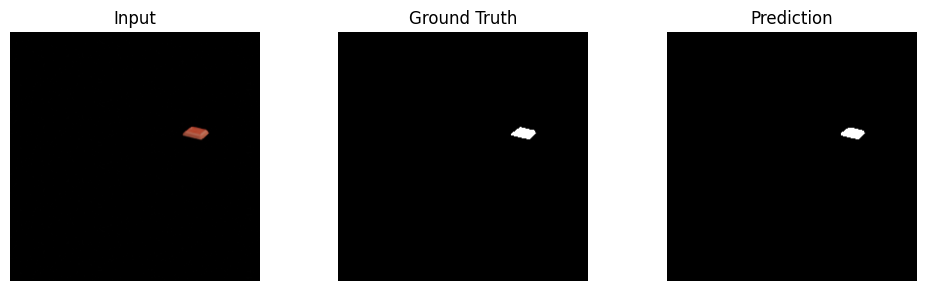

Infer middle frames:  39%|███▉      | 45/114 [00:09<00:15,  4.38it/s]

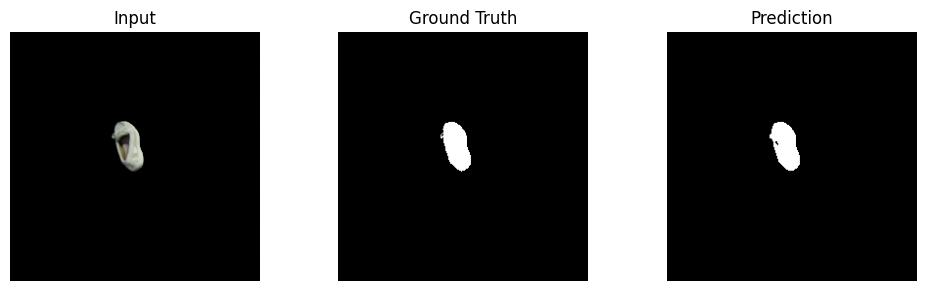

Infer middle frames:  40%|████      | 46/114 [00:09<00:14,  4.69it/s]

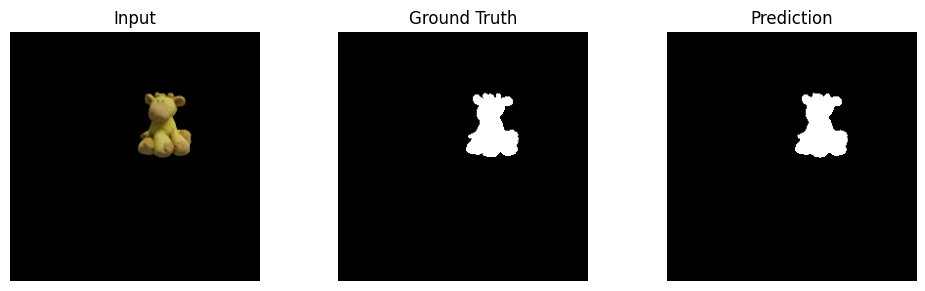

Infer middle frames:  41%|████      | 47/114 [00:09<00:13,  4.97it/s]

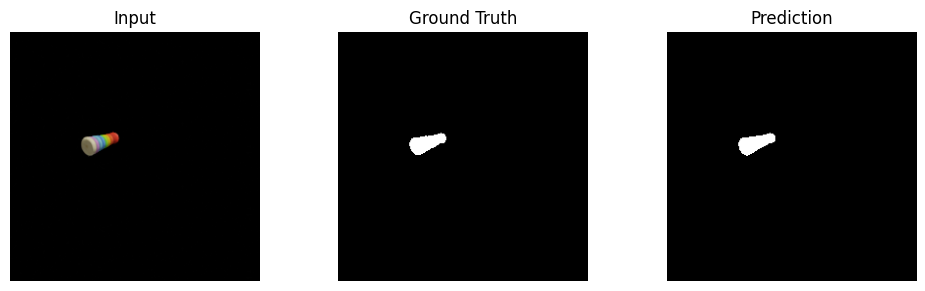

Infer middle frames:  42%|████▏     | 48/114 [00:09<00:12,  5.17it/s]

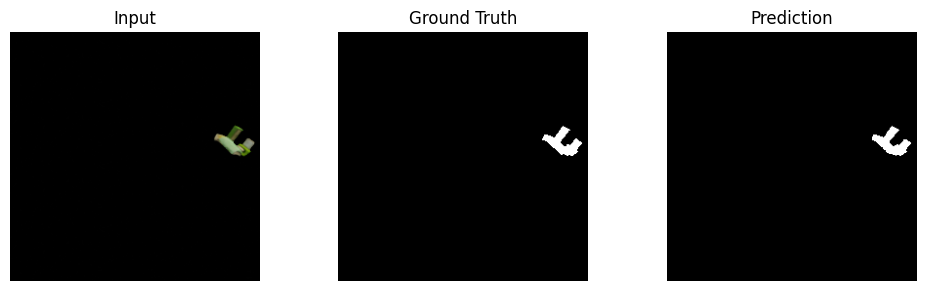

Infer middle frames:  43%|████▎     | 49/114 [00:09<00:12,  5.33it/s]

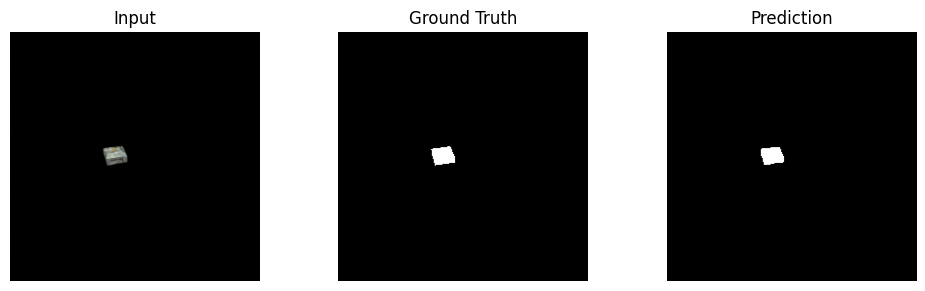

Infer middle frames:  44%|████▍     | 50/114 [00:10<00:11,  5.47it/s]

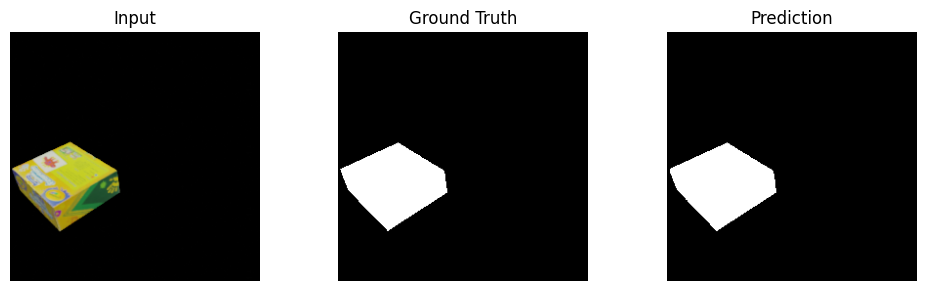

Infer middle frames:  45%|████▍     | 51/114 [00:10<00:11,  5.36it/s]

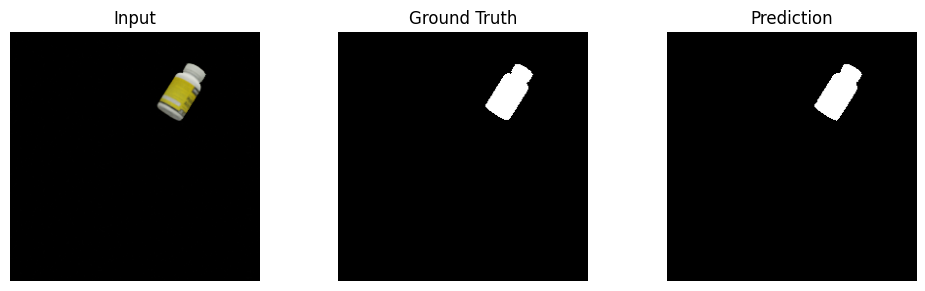

Infer middle frames:  46%|████▌     | 52/114 [00:10<00:11,  5.44it/s]

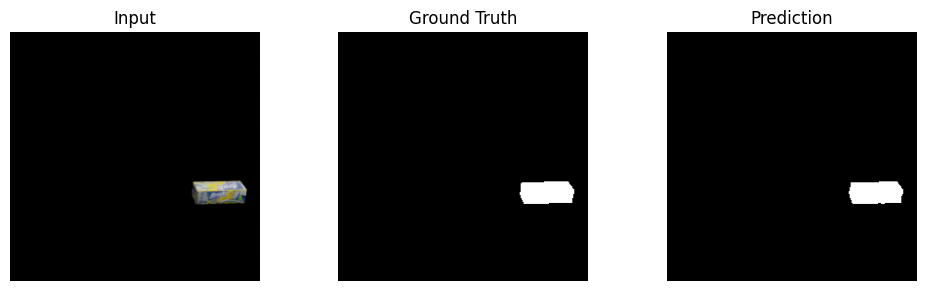

Infer middle frames:  46%|████▋     | 53/114 [00:10<00:11,  5.51it/s]

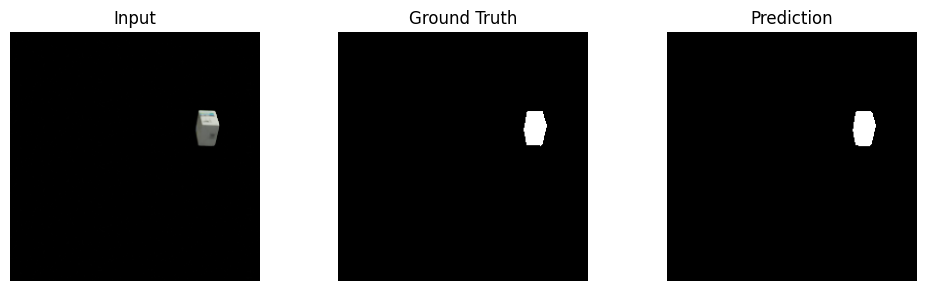

Infer middle frames:  47%|████▋     | 54/114 [00:10<00:10,  5.52it/s]

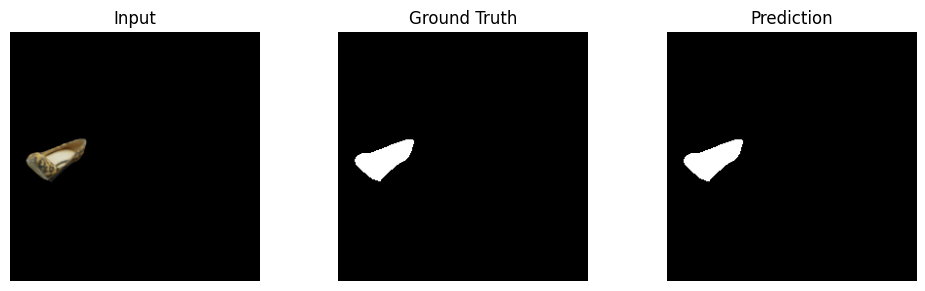

Infer middle frames:  48%|████▊     | 55/114 [00:10<00:10,  5.56it/s]

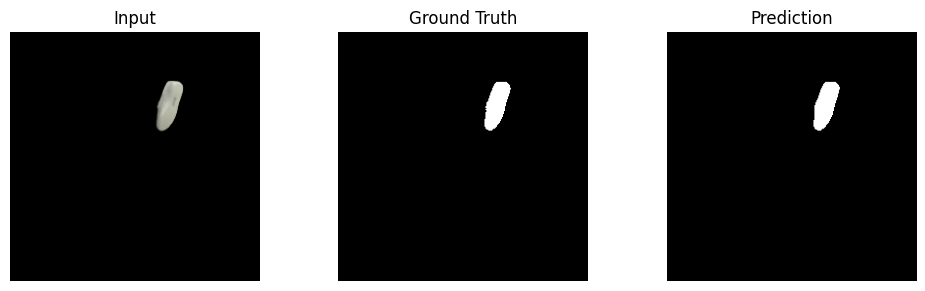

Infer middle frames:  49%|████▉     | 56/114 [00:11<00:10,  5.60it/s]

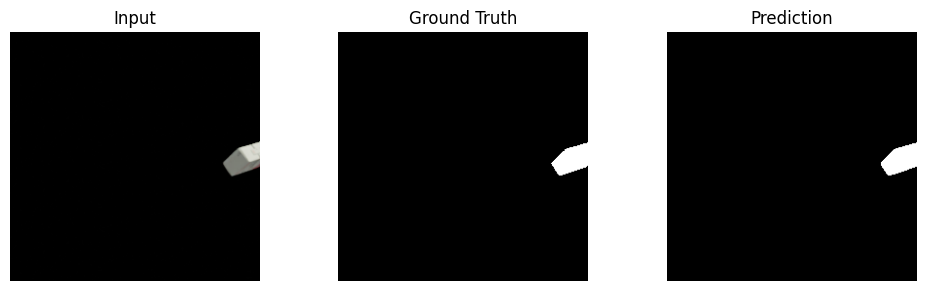

Infer middle frames:  50%|█████     | 57/114 [00:11<00:10,  5.47it/s]

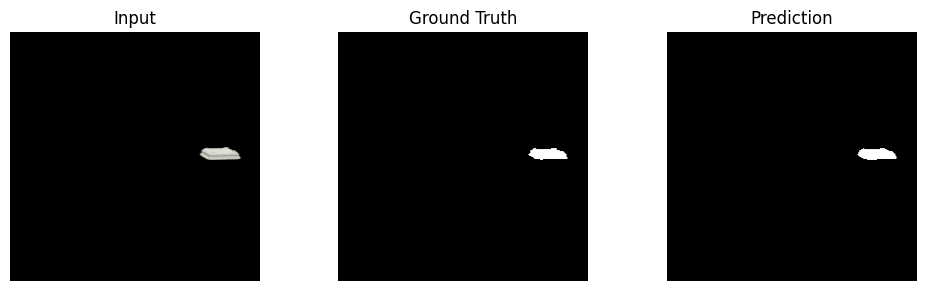

Infer middle frames:  51%|█████     | 58/114 [00:11<00:10,  5.48it/s]

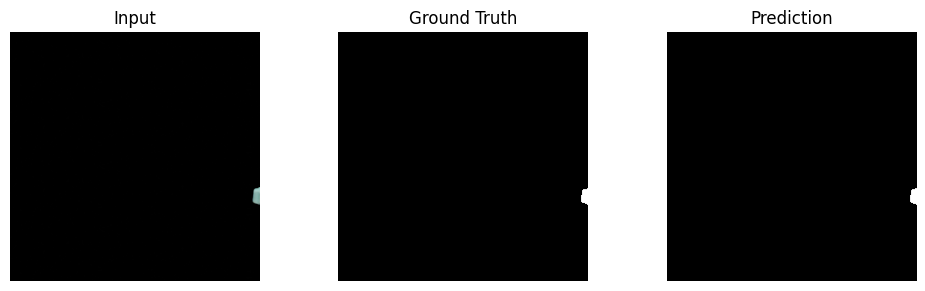

Infer middle frames:  52%|█████▏    | 59/114 [00:11<00:13,  4.07it/s]

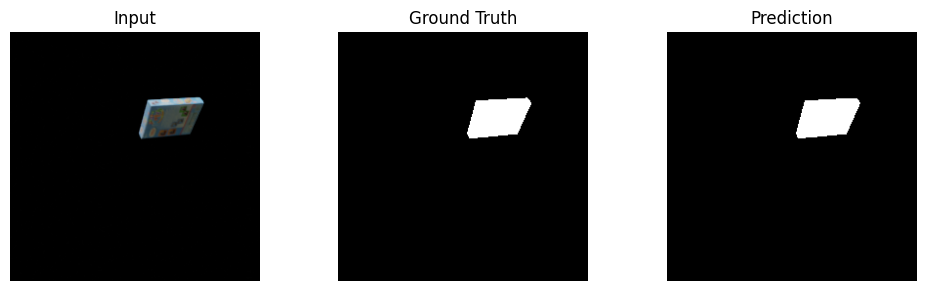

Infer middle frames:  53%|█████▎    | 60/114 [00:12<00:12,  4.45it/s]

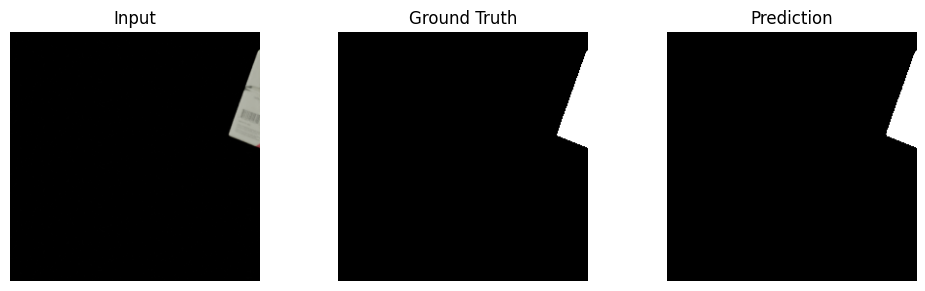

Infer middle frames:  54%|█████▎    | 61/114 [00:12<00:11,  4.65it/s]

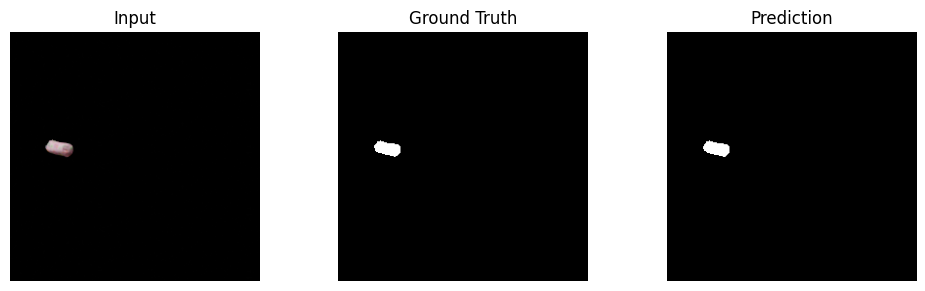

Infer middle frames:  54%|█████▍    | 62/114 [00:12<00:10,  4.89it/s]

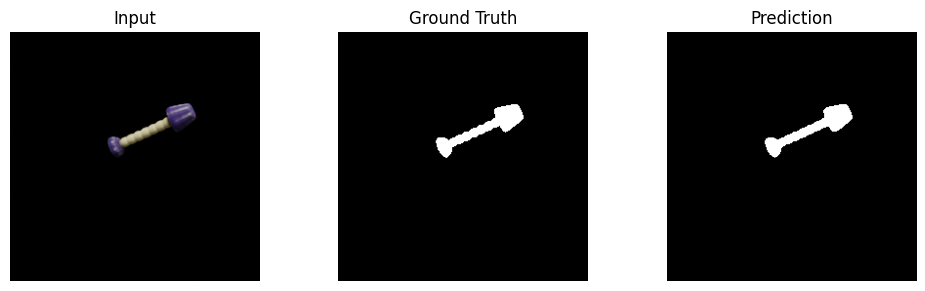

Infer middle frames:  55%|█████▌    | 63/114 [00:12<00:10,  5.10it/s]

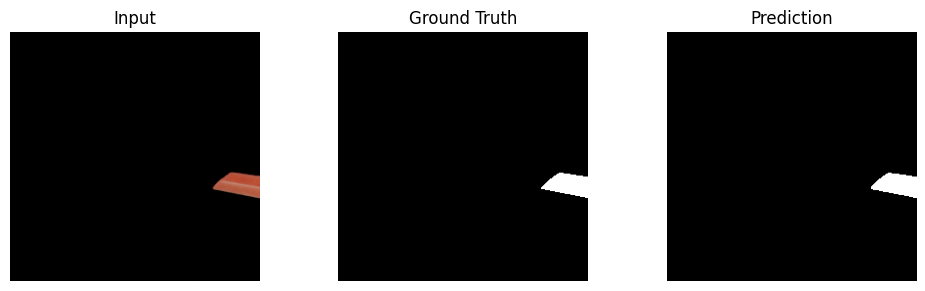

Infer middle frames:  56%|█████▌    | 64/114 [00:12<00:09,  5.23it/s]

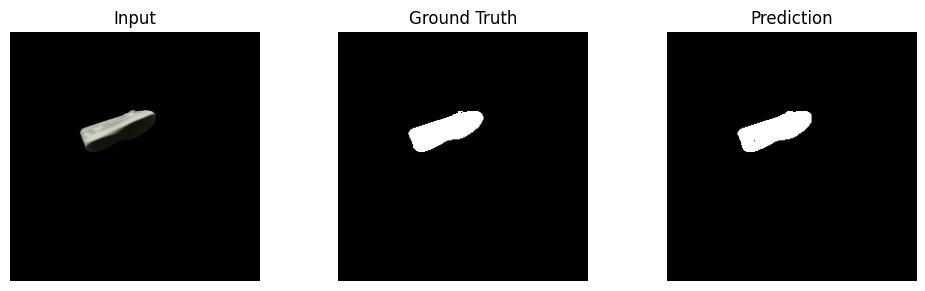

Infer middle frames:  57%|█████▋    | 65/114 [00:13<00:09,  5.35it/s]

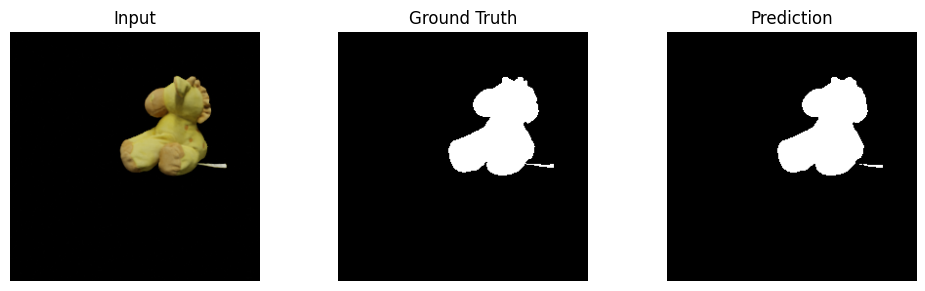

Infer middle frames:  58%|█████▊    | 66/114 [00:13<00:08,  5.44it/s]

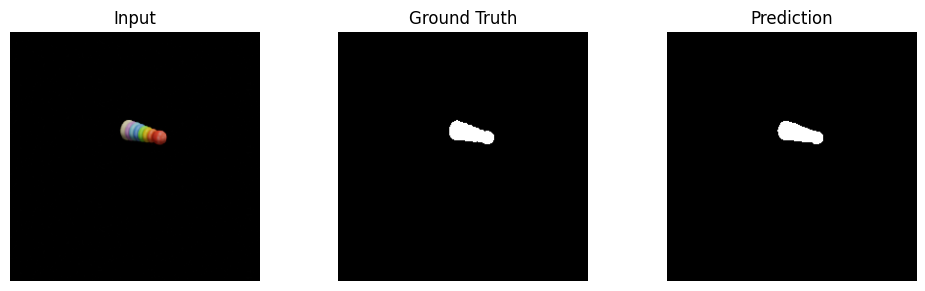

Infer middle frames:  59%|█████▉    | 67/114 [00:13<00:08,  5.37it/s]

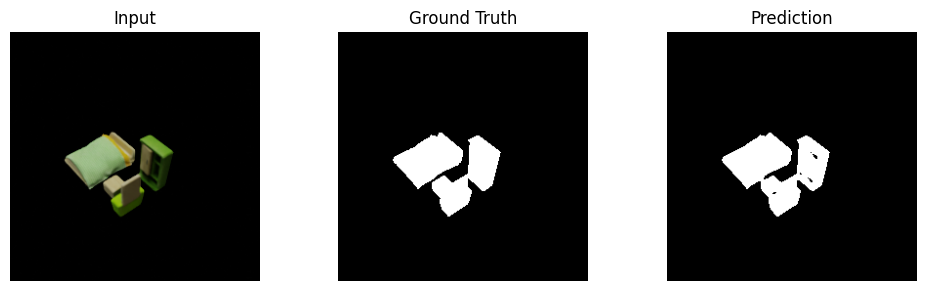

Infer middle frames:  60%|█████▉    | 68/114 [00:13<00:08,  5.42it/s]

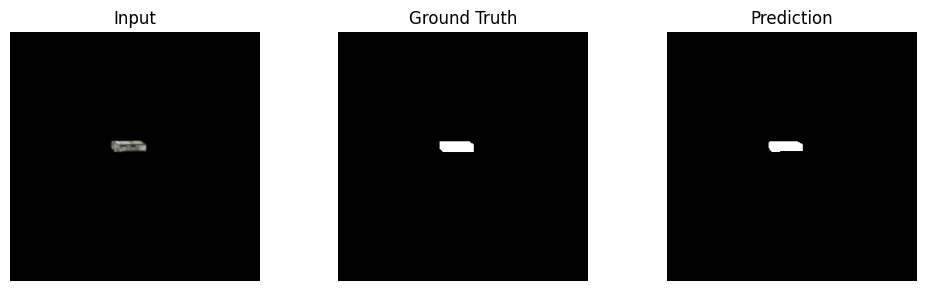

Infer middle frames:  61%|██████    | 69/114 [00:13<00:08,  5.43it/s]

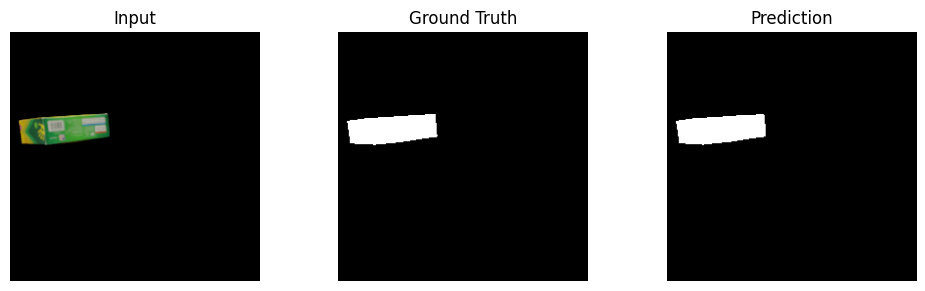

Infer middle frames:  61%|██████▏   | 70/114 [00:13<00:08,  5.47it/s]

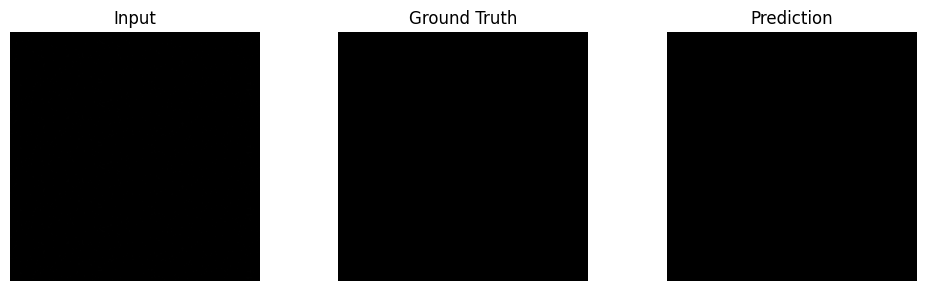

Infer middle frames:  62%|██████▏   | 71/114 [00:14<00:07,  5.49it/s]

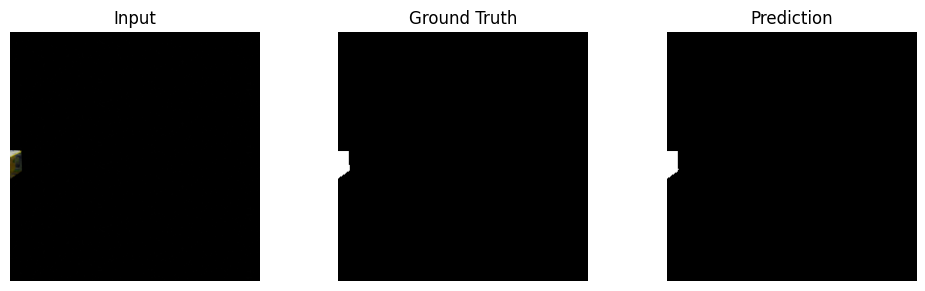

Infer middle frames:  63%|██████▎   | 72/114 [00:14<00:07,  5.45it/s]

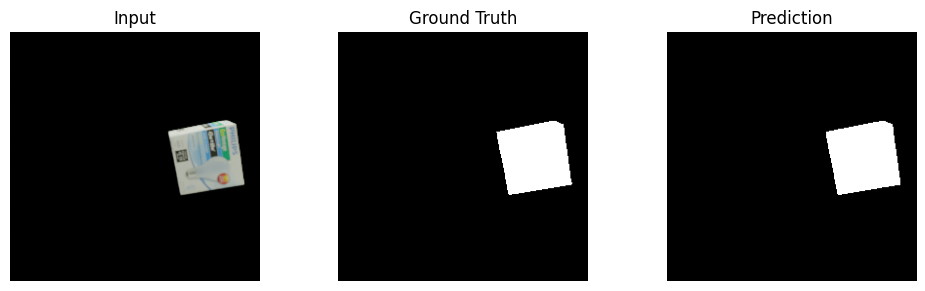

Infer middle frames:  64%|██████▍   | 73/114 [00:14<00:07,  5.41it/s]

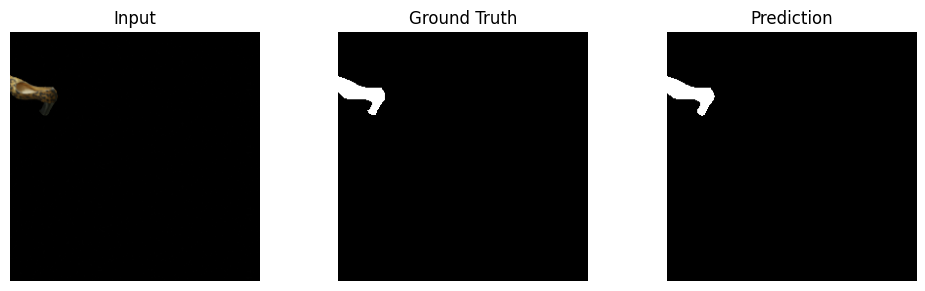

Infer middle frames:  65%|██████▍   | 74/114 [00:14<00:07,  5.46it/s]

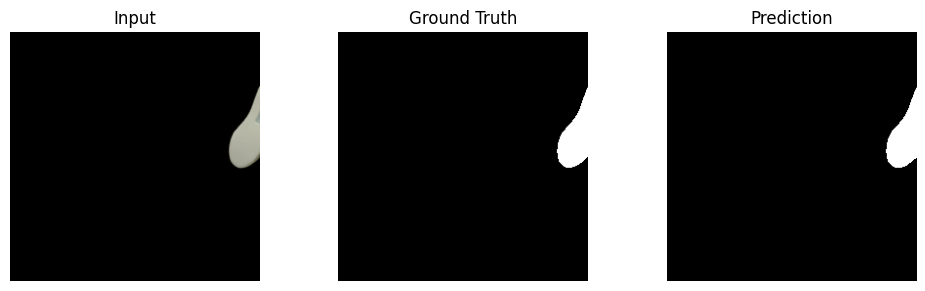

Infer middle frames:  66%|██████▌   | 75/114 [00:14<00:07,  5.52it/s]

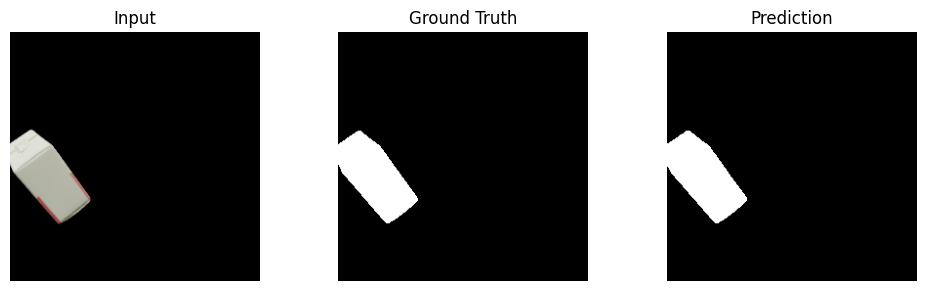

Infer middle frames:  67%|██████▋   | 76/114 [00:15<00:09,  4.08it/s]

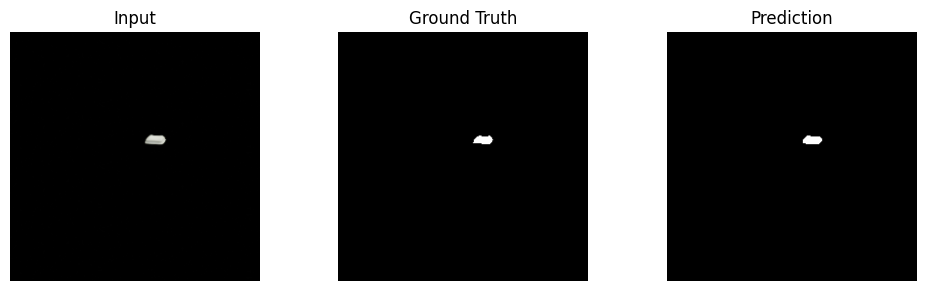

Infer middle frames:  68%|██████▊   | 77/114 [00:15<00:08,  4.35it/s]

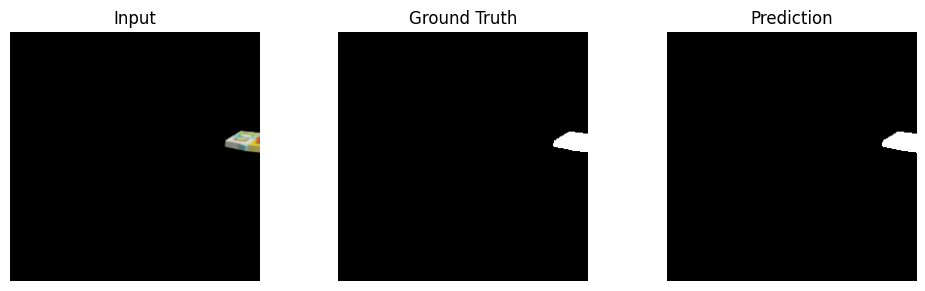

Infer middle frames:  68%|██████▊   | 78/114 [00:15<00:07,  4.66it/s]

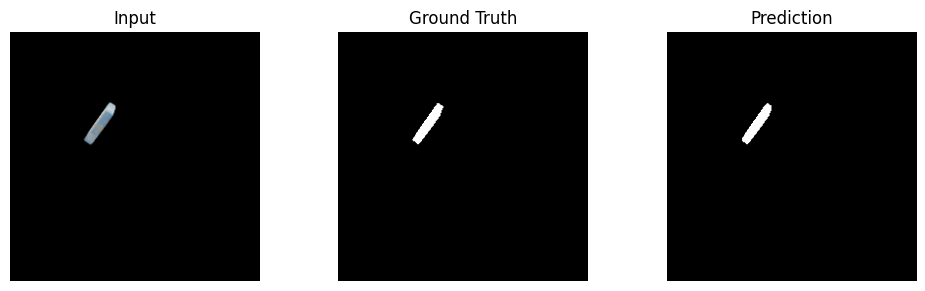

Infer middle frames:  69%|██████▉   | 79/114 [00:15<00:07,  4.91it/s]

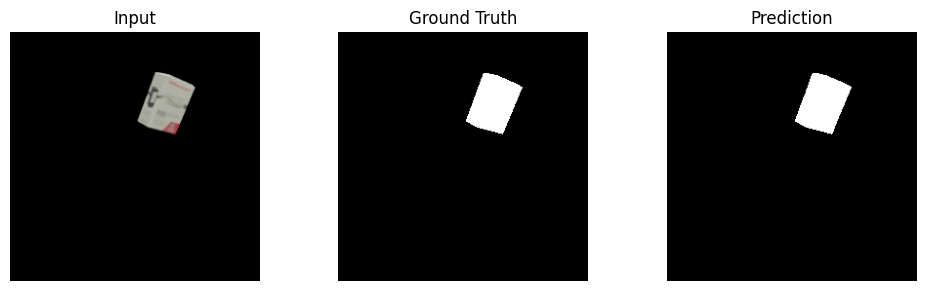

Infer middle frames:  70%|███████   | 80/114 [00:15<00:06,  5.05it/s]

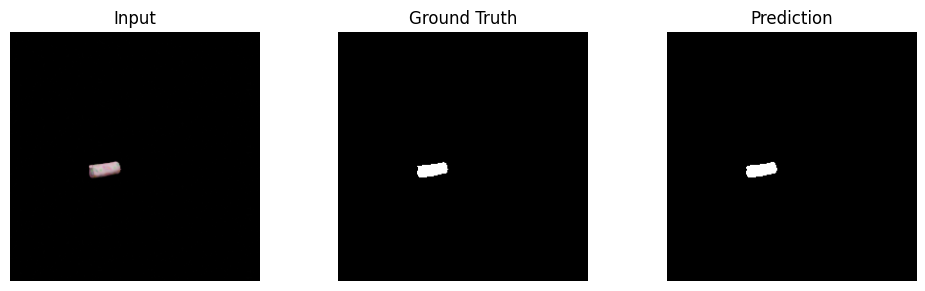

Infer middle frames:  71%|███████   | 81/114 [00:16<00:06,  5.13it/s]

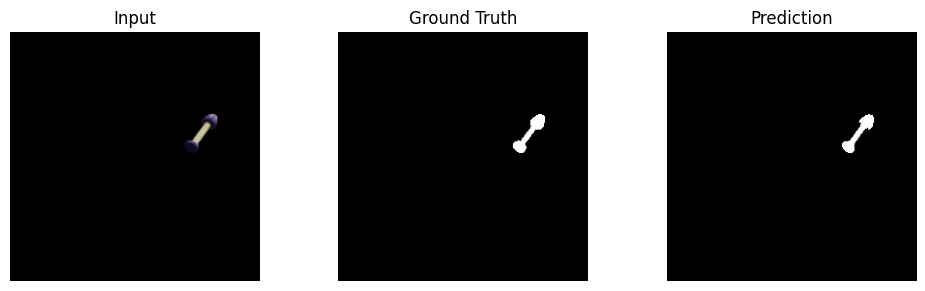

Infer middle frames:  72%|███████▏  | 82/114 [00:16<00:06,  5.22it/s]

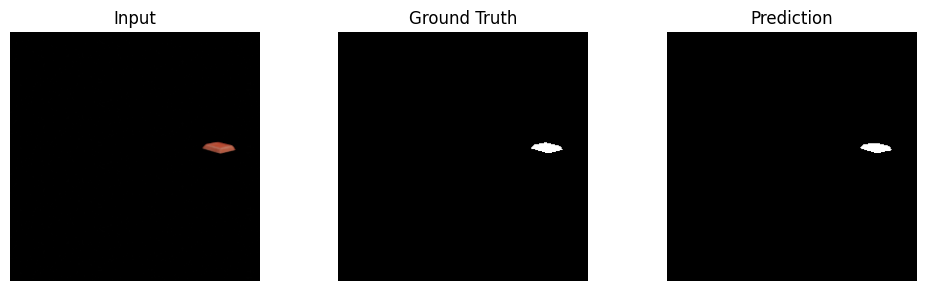

Infer middle frames:  73%|███████▎  | 83/114 [00:16<00:06,  4.94it/s]

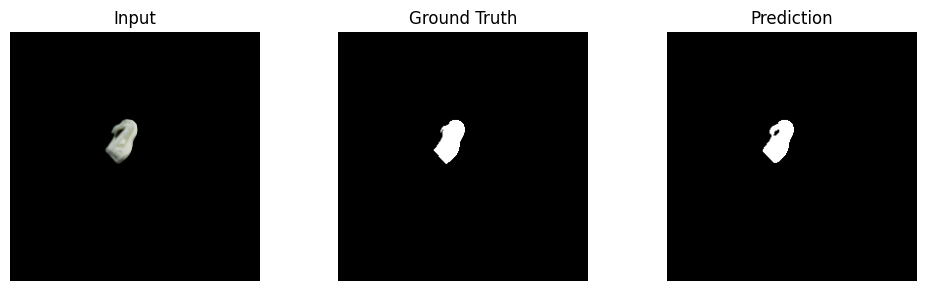

Infer middle frames:  74%|███████▎  | 84/114 [00:16<00:06,  4.92it/s]

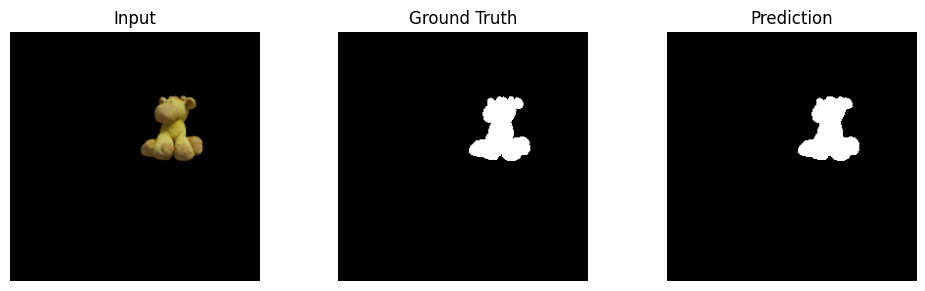

Infer middle frames:  75%|███████▍  | 85/114 [00:16<00:05,  4.92it/s]

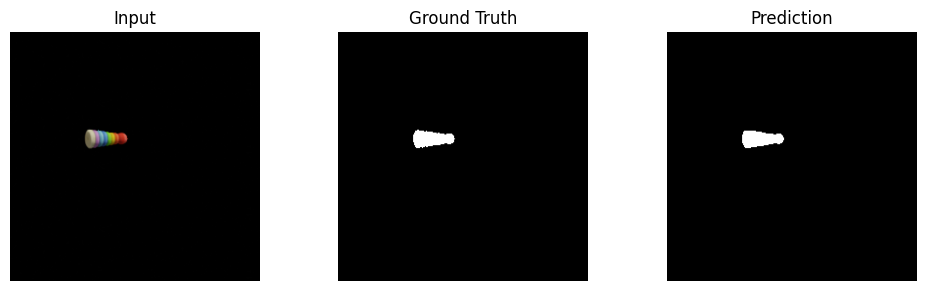

Infer middle frames:  75%|███████▌  | 86/114 [00:17<00:05,  4.96it/s]

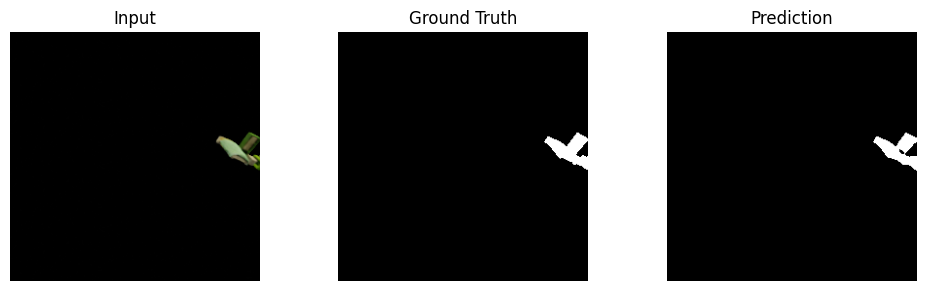

Infer middle frames:  76%|███████▋  | 87/114 [00:17<00:05,  4.78it/s]

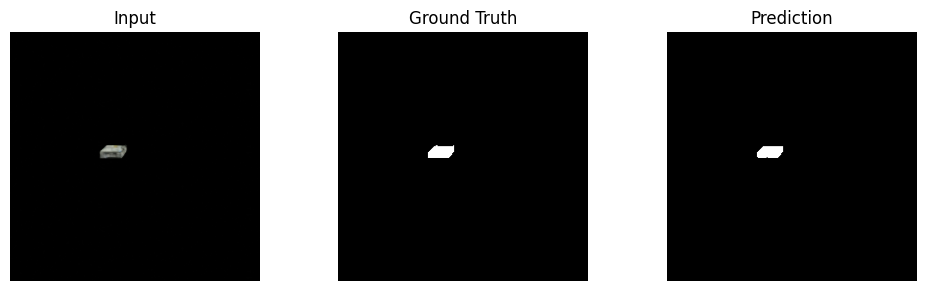

Infer middle frames:  77%|███████▋  | 88/114 [00:17<00:05,  4.39it/s]

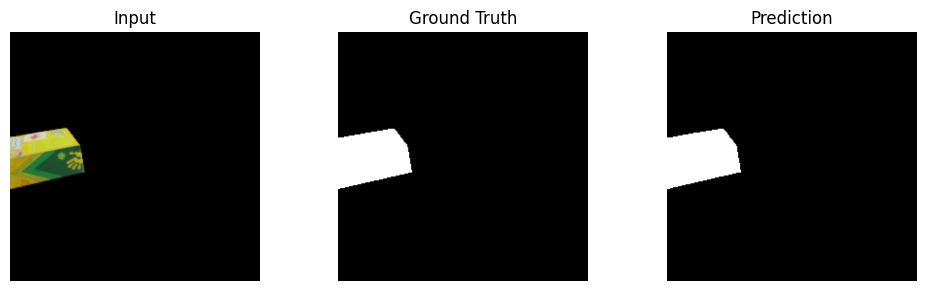

Infer middle frames:  78%|███████▊  | 89/114 [00:17<00:05,  4.22it/s]

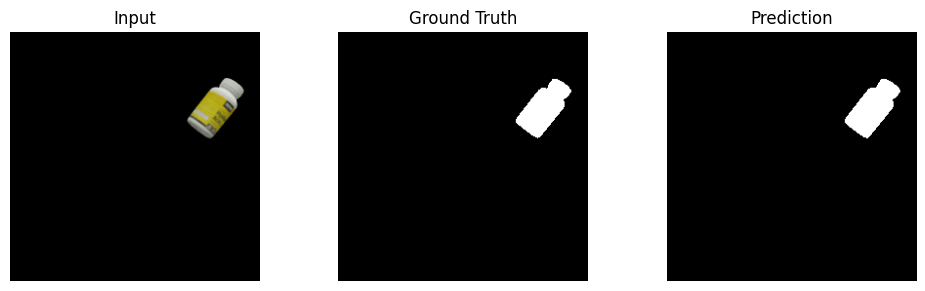

Infer middle frames:  79%|███████▉  | 90/114 [00:18<00:05,  4.10it/s]

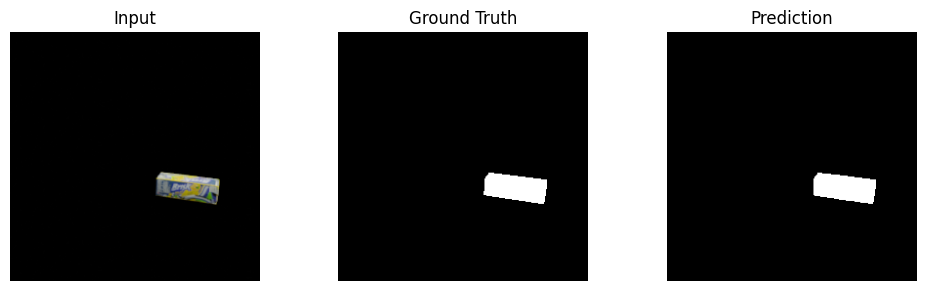

Infer middle frames:  80%|███████▉  | 91/114 [00:18<00:07,  3.14it/s]

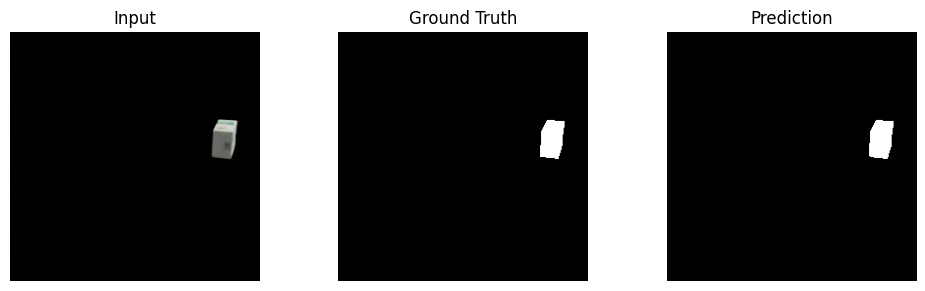

Infer middle frames:  81%|████████  | 92/114 [00:18<00:06,  3.38it/s]

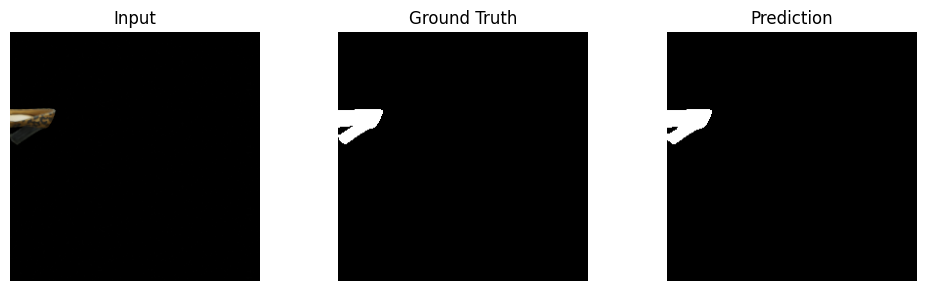

Infer middle frames:  82%|████████▏ | 93/114 [00:19<00:06,  3.49it/s]

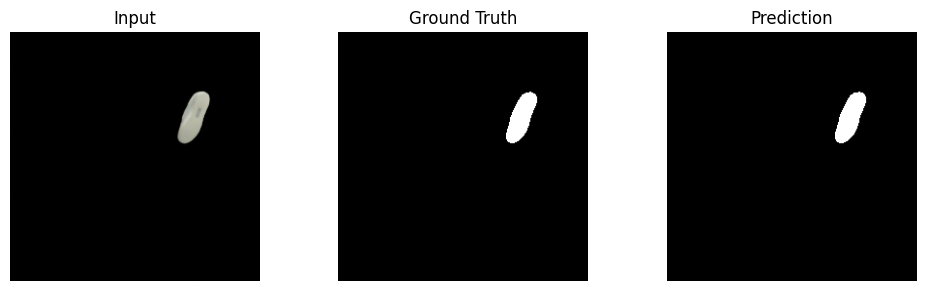

Infer middle frames:  82%|████████▏ | 94/114 [00:19<00:05,  3.65it/s]

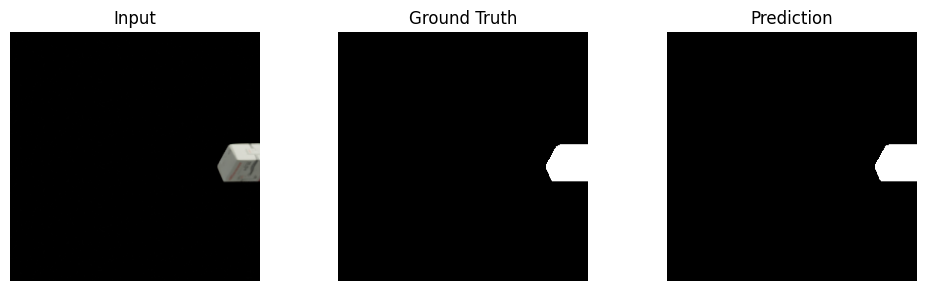

Infer middle frames:  83%|████████▎ | 95/114 [00:19<00:05,  3.65it/s]

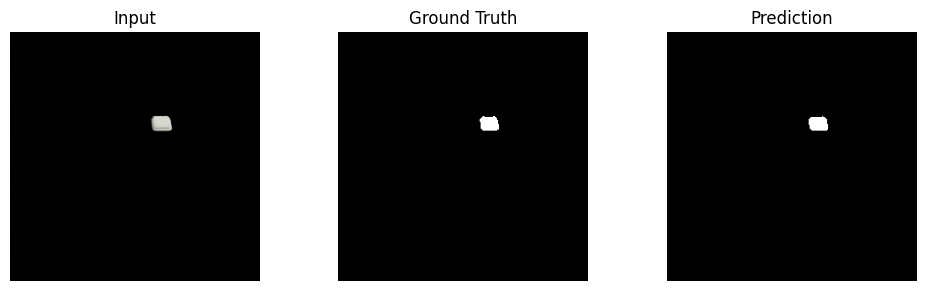

Infer middle frames:  84%|████████▍ | 96/114 [00:19<00:04,  3.68it/s]

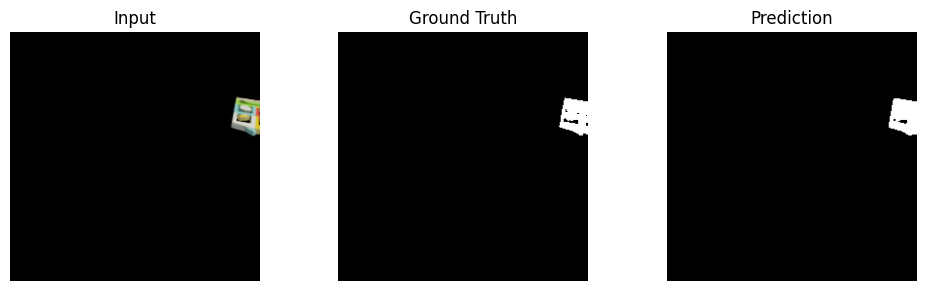

Infer middle frames:  85%|████████▌ | 97/114 [00:20<00:04,  4.06it/s]

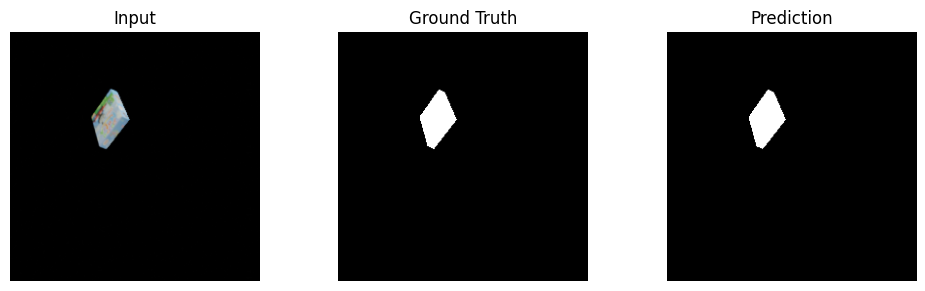

Infer middle frames:  86%|████████▌ | 98/114 [00:20<00:03,  4.35it/s]

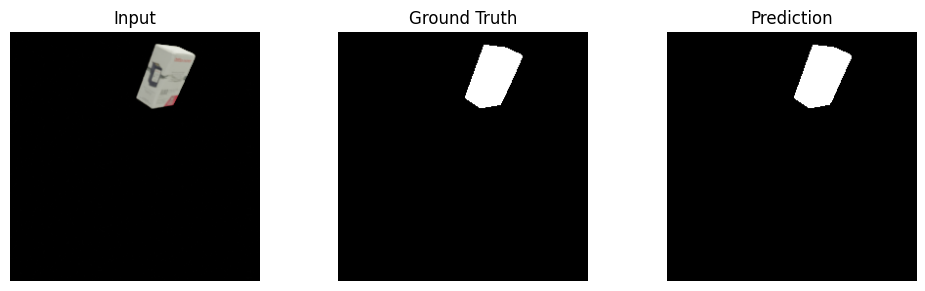

Infer middle frames:  87%|████████▋ | 99/114 [00:20<00:03,  4.62it/s]

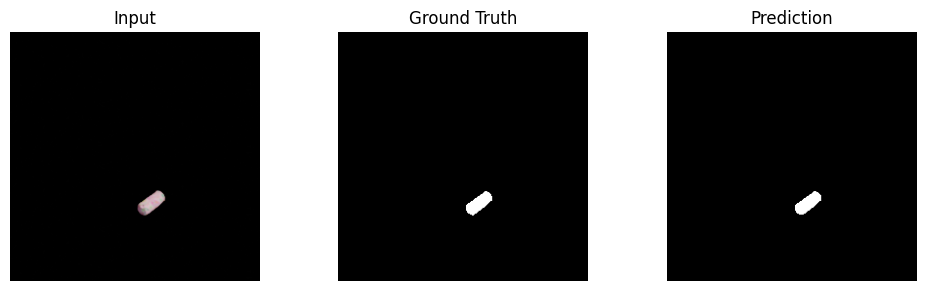

Infer middle frames:  88%|████████▊ | 100/114 [00:20<00:02,  4.71it/s]

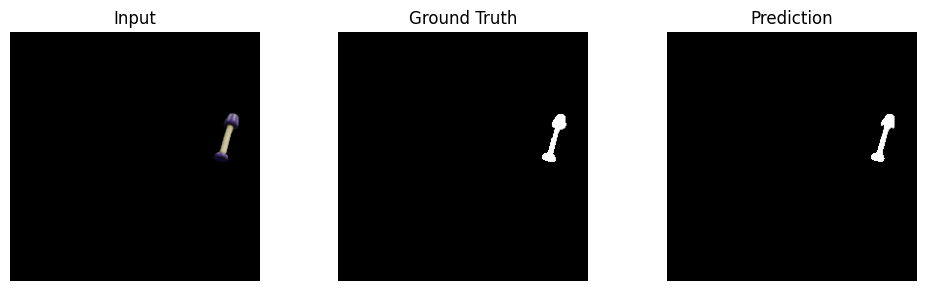

Infer middle frames:  89%|████████▊ | 101/114 [00:20<00:02,  4.91it/s]

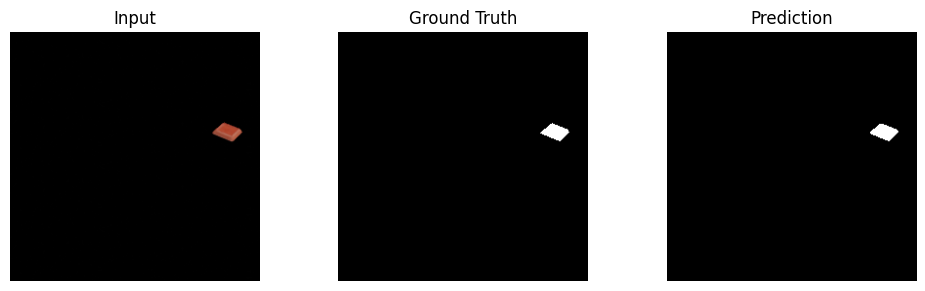

Infer middle frames:  89%|████████▉ | 102/114 [00:21<00:02,  5.04it/s]

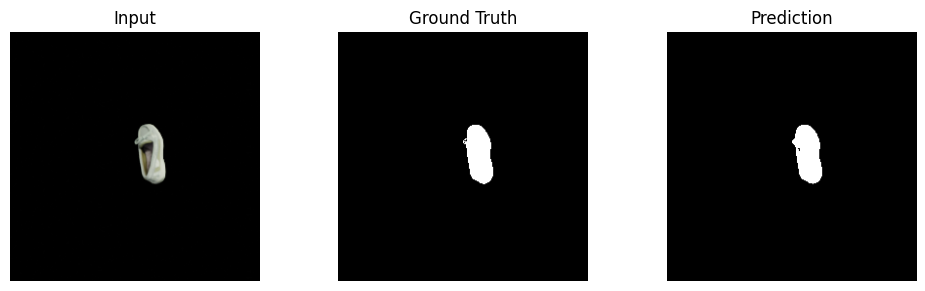

Infer middle frames:  90%|█████████ | 103/114 [00:21<00:02,  5.11it/s]

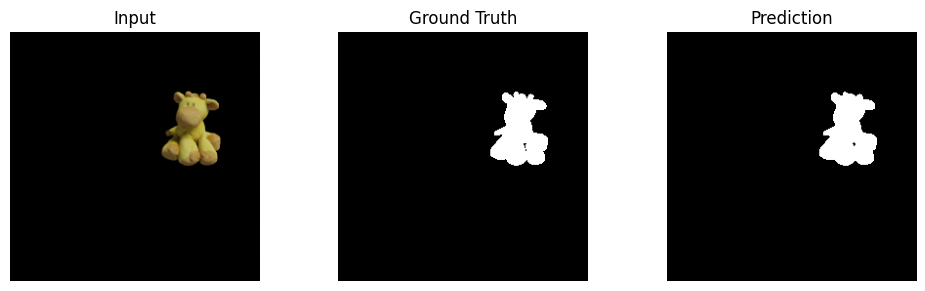

Infer middle frames:  91%|█████████ | 104/114 [00:21<00:01,  5.18it/s]

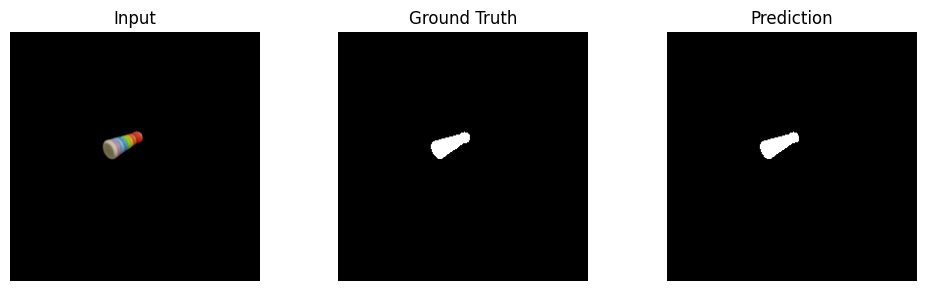

Infer middle frames:  92%|█████████▏| 105/114 [00:21<00:01,  5.09it/s]

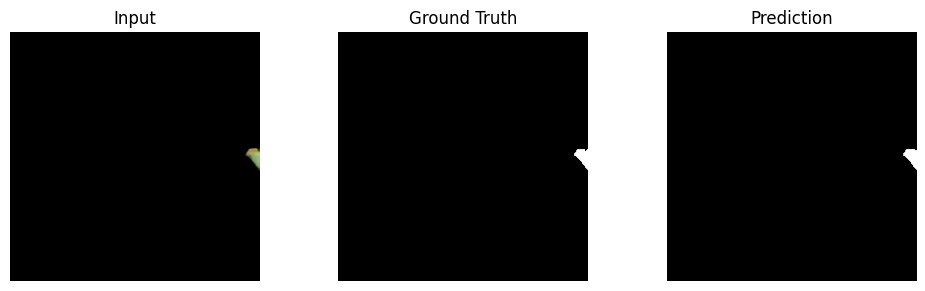

Infer middle frames:  93%|█████████▎| 106/114 [00:22<00:02,  3.92it/s]

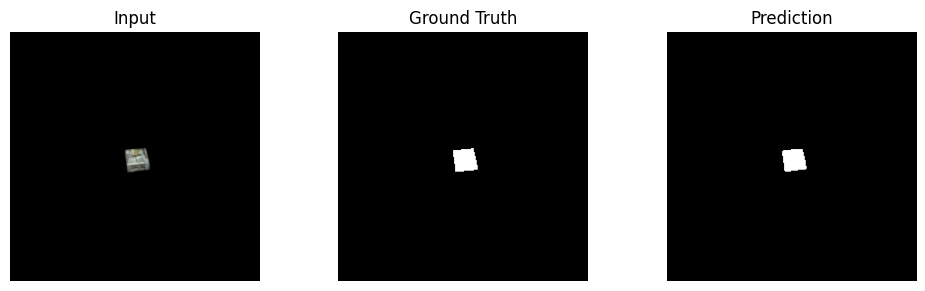

Infer middle frames:  94%|█████████▍| 107/114 [00:22<00:01,  4.26it/s]

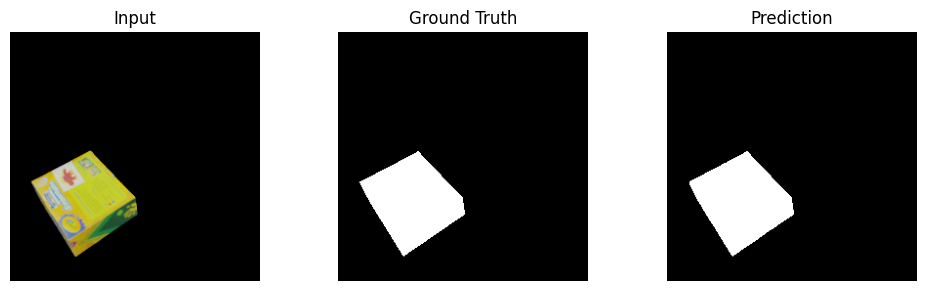

Infer middle frames:  95%|█████████▍| 108/114 [00:22<00:01,  4.53it/s]

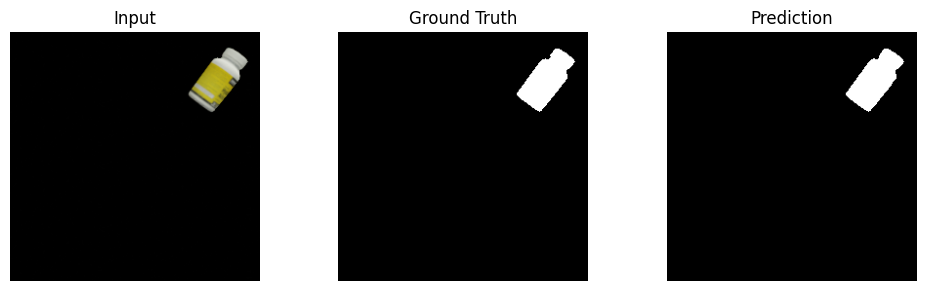

Infer middle frames:  96%|█████████▌| 109/114 [00:22<00:01,  4.69it/s]

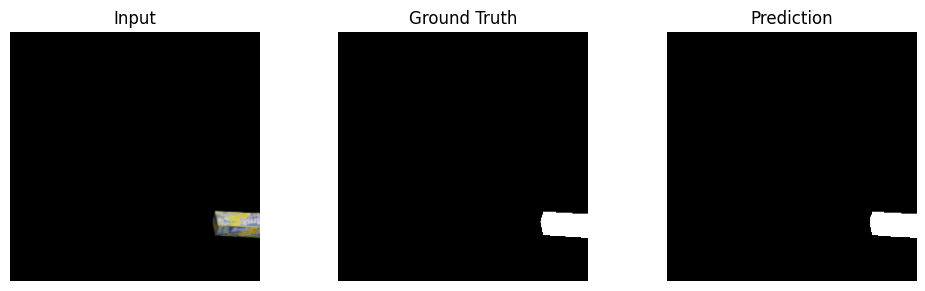

Infer middle frames:  96%|█████████▋| 110/114 [00:22<00:00,  4.75it/s]

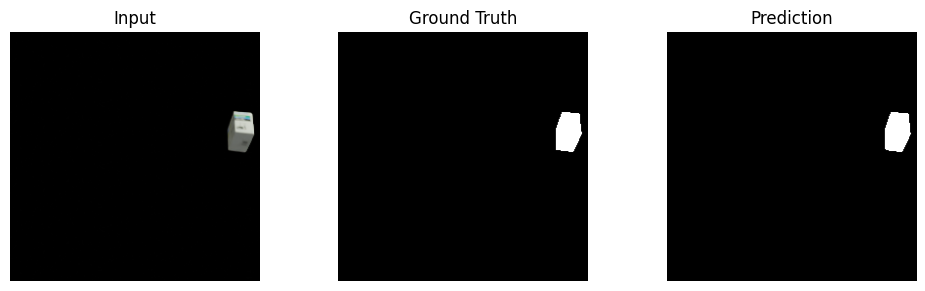

Infer middle frames:  97%|█████████▋| 111/114 [00:23<00:00,  4.87it/s]

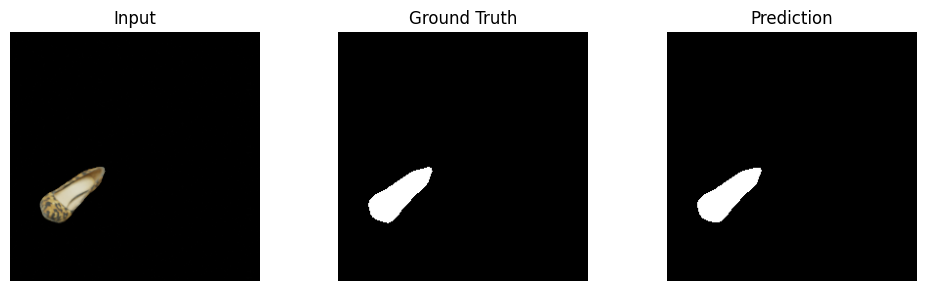

Infer middle frames:  98%|█████████▊| 112/114 [00:23<00:00,  5.00it/s]

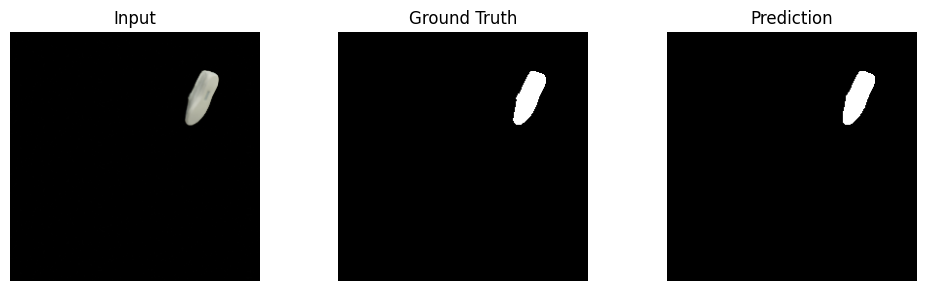

Infer middle frames:  99%|█████████▉| 113/114 [00:23<00:00,  5.09it/s]

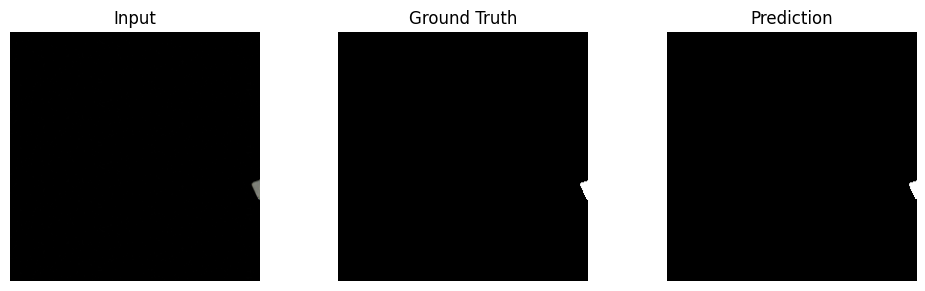

Infer middle frames: 100%|██████████| 114/114 [00:23<00:00,  4.83it/s]


In [22]:
from pathlib import Path
import torch
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# ——— Transforms ————————————————
transform_img = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])
transform_mask = transforms.Resize((256, 256))

# ——— Make sure 'model' is already defined & trained above ———
# If you restarted the runtime, re-define the UNet class and then:
# model = UNet().to(device)
# model.load_state_dict(torch.load("model.pth"))
# model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device).eval()

# ——— Data root & find object folders —————————
root_path   = Path("/content/ff5da6d6ecae486bb294aeaf5ee8f8a1")
obj_folders = sorted(root_path.rglob("obj_*"))
print(f"Found {len(obj_folders)} object folders.")

# ——— Inference loop ——————————————————————
for obj_path in tqdm(obj_folders, desc="Infer middle frames"):
    rgba_files = sorted(obj_path.glob("rgba_*.png"))
    seg_files  = sorted(obj_path.glob("segmentation_*.png"))
    if not rgba_files or not seg_files:
        continue

    mid = len(rgba_files) // 2
    img = Image.open(rgba_files[mid]).convert("RGB")
    gt  = Image.open(seg_files[mid]).convert("L")

    # preprocess
    x = transform_img(img).unsqueeze(0).to(device)
    g = torch.from_numpy(np.array(transform_mask(gt))).long()
    g[g > 0] = 1

    # predict
    with torch.no_grad():
        out      = model(x)                     # (1, 2, H, W)
        pred_np  = torch.argmax(out, dim=1)[0]  # (H, W), values 0 or 1
        pred_np  = pred_np.cpu().numpy()

    # plot
    plt.figure(figsize=(10,3))
    plt.subplot(1,3,1)
    plt.imshow(img);     plt.title("Input");      plt.axis("off")
    plt.subplot(1,3,2)
    plt.imshow(g, cmap="gray"); plt.title("Ground Truth"); plt.axis("off")
    plt.subplot(1,3,3)
    plt.imshow(pred_np, cmap="gray"); plt.title("Prediction"); plt.axis("off")
    plt.tight_layout()
    plt.show()
